In [1]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import time
import copy
import torch_optimizer as optim
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cuda = torch.cuda.is_available()

cpu


In [3]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x
    

def distance(model1, model2):
    return sum([torch.norm(p1 - p2) for p1, p2 in zip(model1.parameters(), model2.parameters())])

def full_loss(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss/len(dataloader)


def train_model(model, optim, criterion, train_loader, epochs=10, verbose=False):
    losses = []
    model.train()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optim.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        full_loss_ = full_loss(model, criterion, train_loader)
        if verbose:
            print(f"Epoch {epoch+1}, running_loss: {running_loss/len(train_loader)}, full_loss: {full_loss_}")
        losses.append(full_loss_)    
    print('Finished Training')
    return losses

In [6]:
# train_X = torch.tensor(train_X).permute(0, 3, 1, 2).float()
# test_X = torch.tensor(test_X).permute(0, 3, 1, 2).float()
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_22200\3739243810.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_22200\3739243810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.int64).to(device)


In [7]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)

hessian_loader = []
for i, (x, y) in enumerate(dataloader):
    hessian_loader.append((x.to(device), y.to(device)))

init_model = Net().to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
# Finding optimal learning rate for each optimizer
lrs = [1e-3, 1e-2, 1e-1, 1, 10]
SGD_losses = []
Adam_losses = []
Adagrad_losses = []
Shampoo_losses = []

for lr in lrs:
    model_SGD = copy.deepcopy(init_model)
    model_Adam = copy.deepcopy(init_model)
    model_Adagrad = copy.deepcopy(init_model)
    model_Shampoo = copy.deepcopy(init_model)
    optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=lr)
    optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=lr)
    optimizer_Adagrad = torch.optim.Adagrad(model_Adagrad.parameters(), lr=lr)
    optimizer_Shampoo = optim.Shampoo(model_Shampoo.parameters(), lr=lr)
    SGD_losses.append(train_model(model_SGD, optimizer_SGD, criterion, dataloader, epochs=15))
    Adam_losses.append(train_model(model_Adam, optimizer_Adam, criterion, dataloader, epochs =15))
    Adagrad_losses.append(train_model(model_Adagrad, optimizer_Adagrad, criterion, dataloader, epochs = 15))
    Shampoo_losses.append(train_model(model_Shampoo, optimizer_Shampoo, criterion, dataloader, epochs = 15))
    print(f"Finished training for lr={lr}, final losses: SGD: {SGD_losses[-1][-1]}, Adam: {Adam_losses[-1][-1]}, Adagrad: {Adagrad_losses[-1][-1]}, Shampoo: {Shampoo_losses[-1][-1]}")

Finished Training
Finished Training
Finished Training
Finished Training
Finished training for lr=0.001, final losses: SGD: 2.192779555916786, Adam: 0.07313902862370014, Adagrad: 0.8271232843399048, Shampoo: 2.266898401081562
Finished Training
Finished Training
Finished Training
Finished Training
Finished training for lr=0.01, final losses: SGD: 0.9566995296627283, Adam: 0.0008256580267698155, Adagrad: 0.09991984197404236, Shampoo: 1.998801089823246
Finished Training
Finished Training
Finished Training
Finished Training
Finished training for lr=0.1, final losses: SGD: 0.15163837472209707, Adam: 0.6983137642964721, Adagrad: 0.007225337627460249, Shampoo: 0.323598759714514
Finished Training
Finished Training
Finished Training
Finished Training
Finished training for lr=1, final losses: SGD: 0.014026412223756779, Adam: 2.3022340163588524, Adagrad: 0.8022051444277167, Shampoo: 0.004900671876384877
Finished Training
Finished Training
Finished Training
Finished Training
Finished training for l

In [9]:
minindex_SGD = np.argmin([np.mean(SGD_losses[i][10:]) for i in range(len(SGD_losses))])
minindex_Adam = np.argmin([np.mean(Adam_losses[i][10:]) for i in range(len(Adam_losses))])
minindex_Adagrad = np.argmin([np.mean(Adagrad_losses[i][10:]) for i in range(len(Adagrad_losses))])
minindex_Shampoo = np.argmin([np.mean(Shampoo_losses[i][10:]) for i in range(len(Shampoo_losses))])
sgd_lr = lrs[minindex_SGD]
adam_lr = lrs[minindex_Adam]
adagrad_lr = lrs[minindex_Adagrad]
shampoo_lr = lrs[minindex_Shampoo]
print(f"SGD: {sgd_lr}, Adam: {adam_lr}, Adagrad: {adagrad_lr}, Shampoo: {shampoo_lr}")

SGD: 1, Adam: 0.01, Adagrad: 0.1, Shampoo: 10


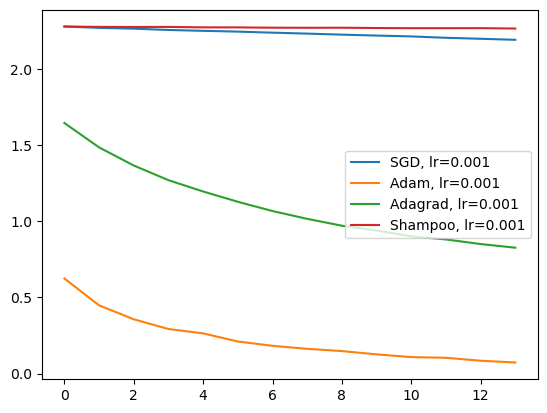

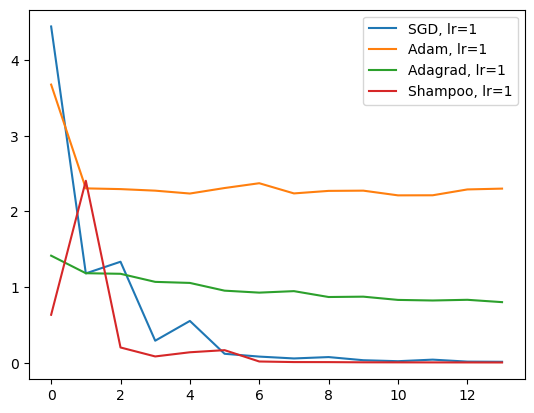

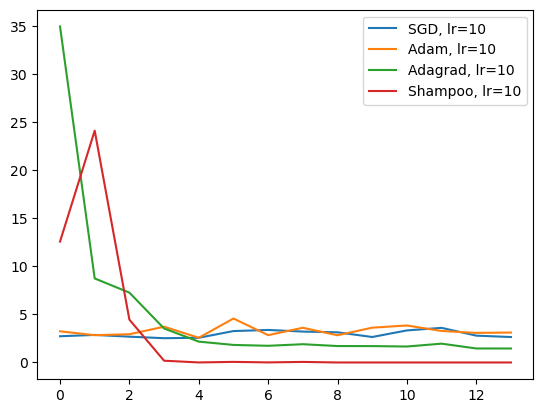

In [10]:
# Plotting training curves for different optimizers
for lr in range(len(lrs)):
    plt.plot(SGD_losses[lr][1:], label=f"SGD, lr={lrs[lr]}")
    plt.plot(Adam_losses[lr][1:], label=f"Adam, lr={lrs[lr]}")
    plt.plot(Adagrad_losses[lr][1:], label=f"Adagrad, lr={lrs[lr]}")
    plt.plot(Shampoo_losses[lr][1:], label=f"Shampoo, lr={lrs[lr]}")
    plt.legend()
    plt.show()

In [11]:
model_SGD = copy.deepcopy(init_model)
model_Adam = copy.deepcopy(init_model)
model_Adagrad = copy.deepcopy(init_model)
model_Shampoo = copy.deepcopy(init_model)
init_model = copy.deepcopy(init_model)

In [12]:
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=lrs[minindex_SGD])
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=lrs[minindex_Adam])
optimizer_Adagrad = torch.optim.Adagrad(model_Adagrad.parameters(), lr=lrs[minindex_Adagrad])
optimizer_Shampoo = optim.Shampoo(model_Shampoo.parameters(), lr=lrs[minindex_Shampoo])

d:\miniconda3\envs\deephessian\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/30, Batch 1/32, Loss_SGD: 2.275669813156128, Loss_Adam: 2.275669813156128, Loss_Adagrad: 2.275669813156128, Loss_Shampoo: 2.275669813156128
Epoch 1/30, Batch 2/32, Loss_SGD: 2.283811092376709, Loss_Adam: 2.219780683517456, Loss_Adagrad: 21.36970329284668, Loss_Shampoo: 573.9473876953125
Epoch 1/30, Batch 3/32, Loss_SGD: 2.226752519607544, Loss_Adam: 1.899973750114441, Loss_Adagrad: 16.938709259033203, Loss_Shampoo: 279.37200927734375
Epoch 1/30, Batch 4/32, Loss_SGD: 2.730119466781616, Loss_Adam: 1.852591633796692, Loss_Adagrad: 18.230974197387695, Loss_Shampoo: 495.05035400390625
Epoch 1/30, Batch 5/32, Loss_SGD: 2.3106534481048584, Loss_Adam: 1.5011844635009766, Loss_Adagrad: 12.332290649414062, Loss_Shampoo: 463.57733154296875
Epoch 1/30, Batch 6/32, Loss_SGD: 2.2096147537231445, Loss_Adam: 1.3917343616485596, Loss_Adagrad: 4.946069240570068, Loss_Shampoo: 228.33628845214844
Epoch 1/30, Batch 7/32, Loss_SGD: 1.9843980073928833, Loss_Adam: 1.2669968605041504, Loss_Adagrad: 2.

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


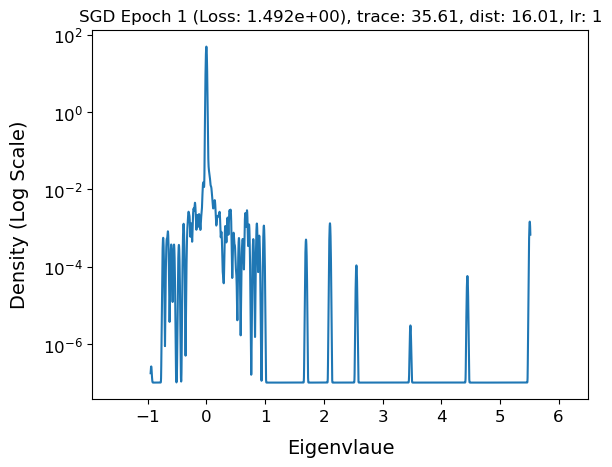

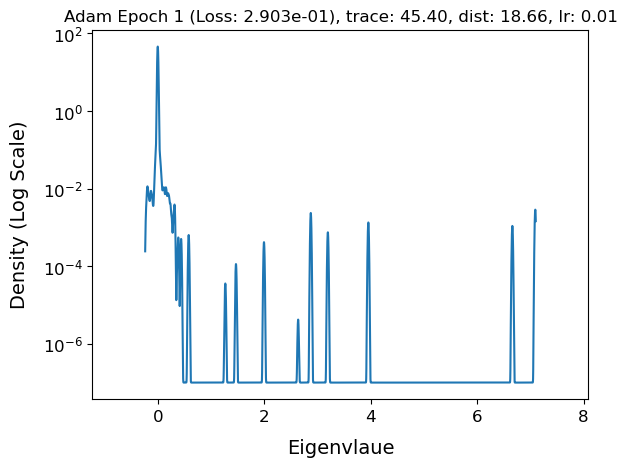

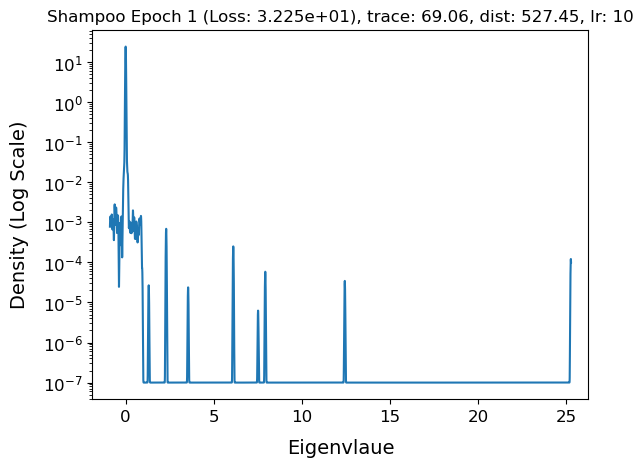

Epoch 2/30, Batch 1/32, Loss_SGD: 1.095249056816101, Loss_Adam: 0.13745145499706268, Loss_Adagrad: 0.31764325499534607, Loss_Shampoo: 27.166748046875
Epoch 2/30, Batch 2/32, Loss_SGD: 1.3053208589553833, Loss_Adam: 0.22669073939323425, Loss_Adagrad: 0.31659016013145447, Loss_Shampoo: 17.124778747558594
Epoch 2/30, Batch 3/32, Loss_SGD: 1.7982193231582642, Loss_Adam: 0.3183506727218628, Loss_Adagrad: 0.25365281105041504, Loss_Shampoo: 13.589641571044922
Epoch 2/30, Batch 4/32, Loss_SGD: 1.289184331893921, Loss_Adam: 0.32620105147361755, Loss_Adagrad: 0.24916765093803406, Loss_Shampoo: 22.770978927612305
Epoch 2/30, Batch 5/32, Loss_SGD: 1.5592846870422363, Loss_Adam: 0.8411304950714111, Loss_Adagrad: 0.48306769132614136, Loss_Shampoo: 14.870898246765137
Epoch 2/30, Batch 6/32, Loss_SGD: 1.0167720317840576, Loss_Adam: 0.4922444224357605, Loss_Adagrad: 0.4750896096229553, Loss_Shampoo: 27.365447998046875
Epoch 2/30, Batch 7/32, Loss_SGD: 1.1077324151992798, Loss_Adam: 0.26702356338500977,

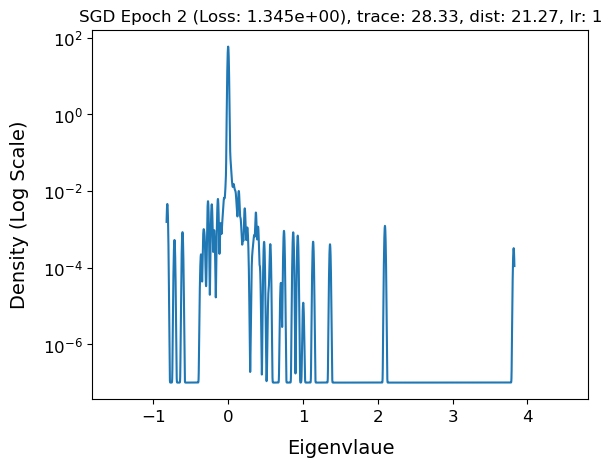

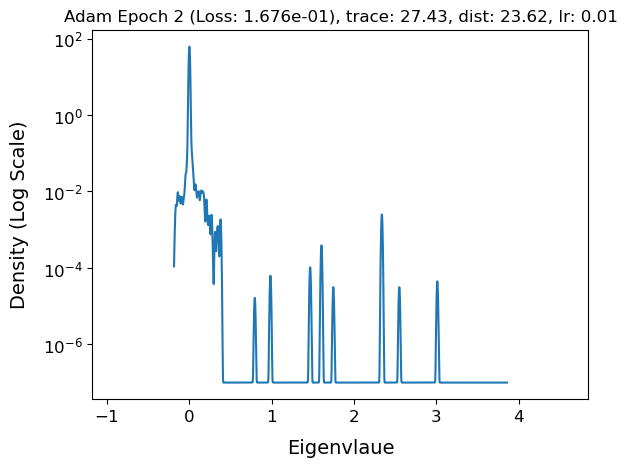

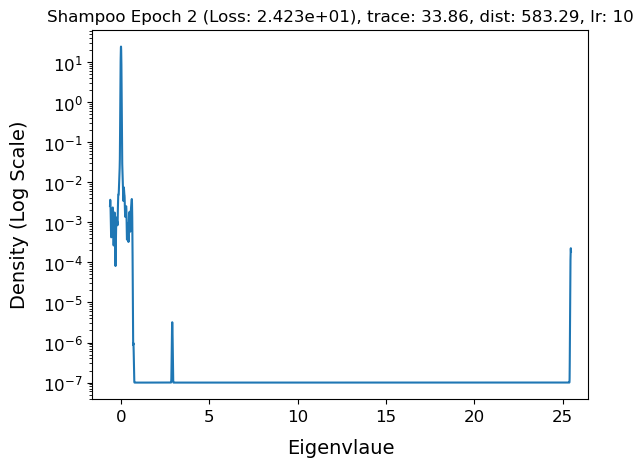

Epoch 3/30, Batch 1/32, Loss_SGD: 2.1055116653442383, Loss_Adam: 0.21691980957984924, Loss_Adagrad: 0.2716156840324402, Loss_Shampoo: 32.714942932128906
Epoch 3/30, Batch 2/32, Loss_SGD: 1.1698315143585205, Loss_Adam: 0.1572016030550003, Loss_Adagrad: 0.301974356174469, Loss_Shampoo: 10.913835525512695
Epoch 3/30, Batch 3/32, Loss_SGD: 1.2556794881820679, Loss_Adam: 0.1788254827260971, Loss_Adagrad: 0.3868854343891144, Loss_Shampoo: 26.95363426208496
Epoch 3/30, Batch 4/32, Loss_SGD: 0.5844991207122803, Loss_Adam: 0.18462654948234558, Loss_Adagrad: 0.1857701987028122, Loss_Shampoo: 19.11330223083496
Epoch 3/30, Batch 5/32, Loss_SGD: 0.8099274635314941, Loss_Adam: 0.12335836887359619, Loss_Adagrad: 0.13260871171951294, Loss_Shampoo: 11.568258285522461
Epoch 3/30, Batch 6/32, Loss_SGD: 0.5099347233772278, Loss_Adam: 0.10673996061086655, Loss_Adagrad: 0.11457788944244385, Loss_Shampoo: 9.780988693237305
Epoch 3/30, Batch 7/32, Loss_SGD: 0.9765433073043823, Loss_Adam: 0.31164467334747314, 

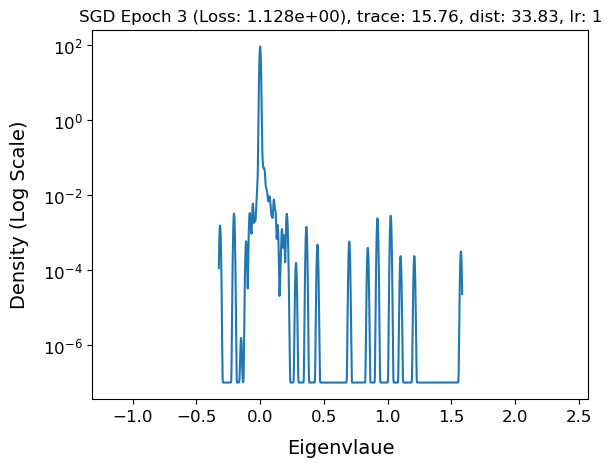

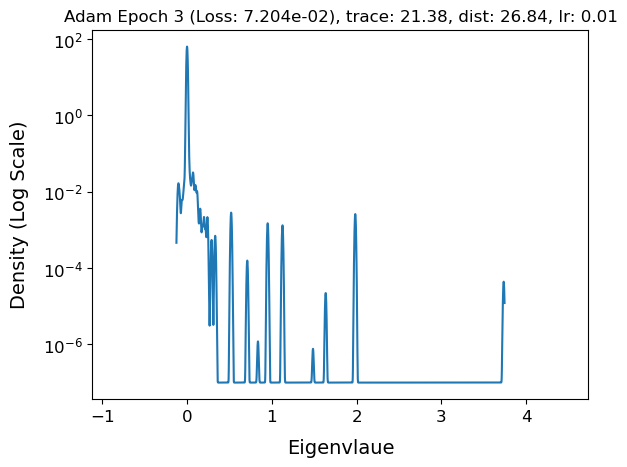

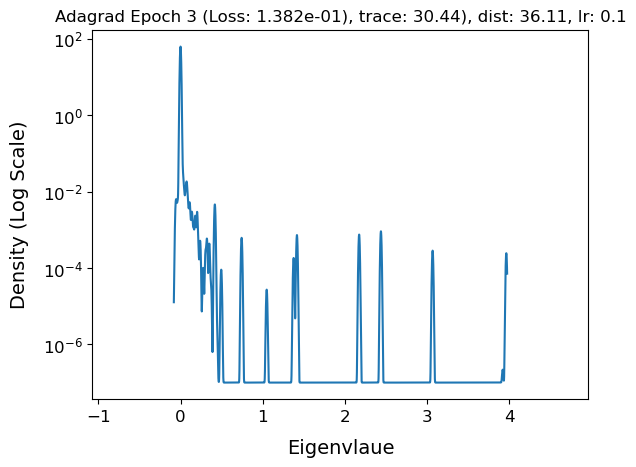

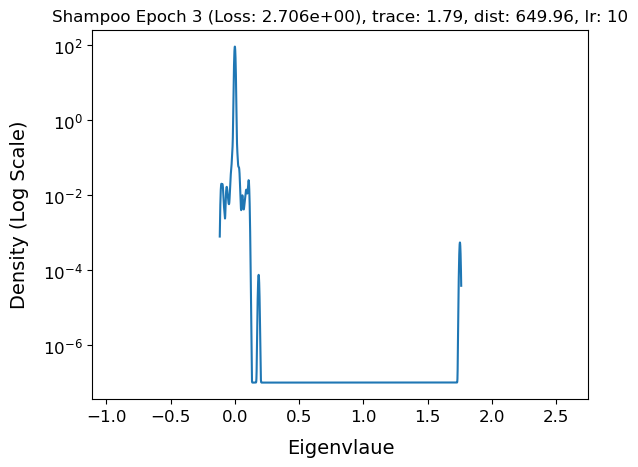

Epoch 4/30, Batch 1/32, Loss_SGD: 1.5890134572982788, Loss_Adam: 0.17300797998905182, Loss_Adagrad: 0.30283665657043457, Loss_Shampoo: 6.06770658493042
Epoch 4/30, Batch 2/32, Loss_SGD: 0.9867761135101318, Loss_Adam: 0.03224337473511696, Loss_Adagrad: 0.05794597044587135, Loss_Shampoo: 2.287883758544922
Epoch 4/30, Batch 3/32, Loss_SGD: 1.2820208072662354, Loss_Adam: 0.05507027730345726, Loss_Adagrad: 0.13635282218456268, Loss_Shampoo: 0.8831453323364258
Epoch 4/30, Batch 4/32, Loss_SGD: 1.3018101453781128, Loss_Adam: 0.15549783408641815, Loss_Adagrad: 0.2692590057849884, Loss_Shampoo: 5.328548431396484
Epoch 4/30, Batch 5/32, Loss_SGD: 1.0596129894256592, Loss_Adam: 0.09397821873426437, Loss_Adagrad: 0.11667655408382416, Loss_Shampoo: 6.034911734786874e-07
Epoch 4/30, Batch 6/32, Loss_SGD: 1.0436961650848389, Loss_Adam: 0.036930762231349945, Loss_Adagrad: 0.18068274855613708, Loss_Shampoo: 0.3106674253940582
Epoch 4/30, Batch 7/32, Loss_SGD: 0.9176021218299866, Loss_Adam: 0.0706237852

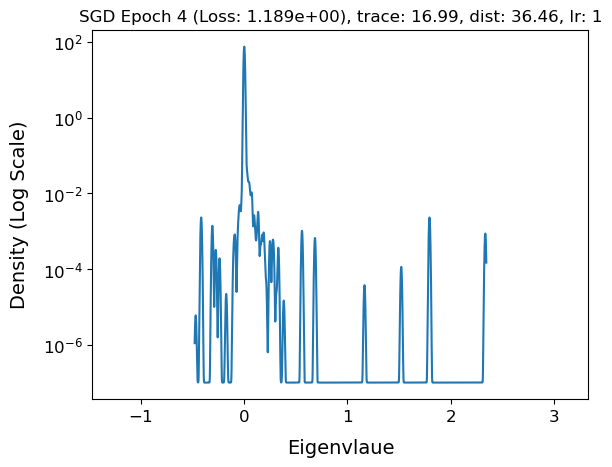

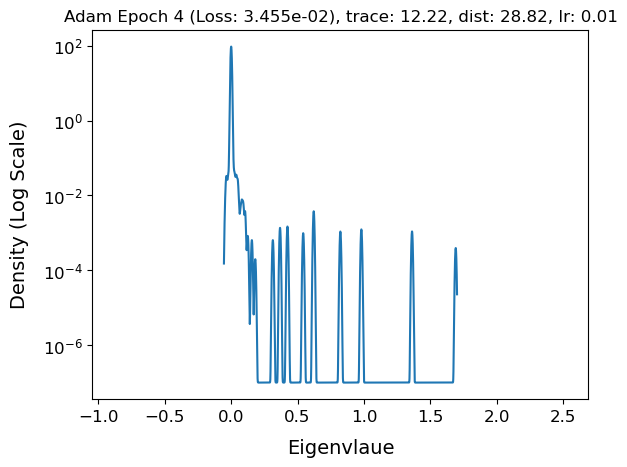

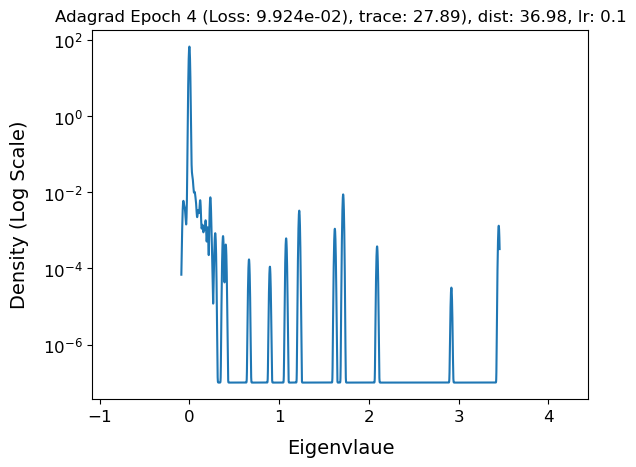

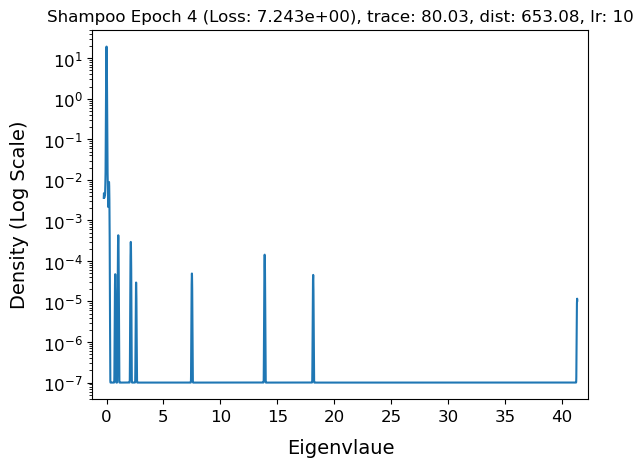

Epoch 5/30, Batch 1/32, Loss_SGD: 1.2685794830322266, Loss_Adam: 0.015318707562983036, Loss_Adagrad: 0.07352431118488312, Loss_Shampoo: 2.989569664001465
Epoch 5/30, Batch 2/32, Loss_SGD: 0.8188521862030029, Loss_Adam: 0.016039976850152016, Loss_Adagrad: 0.038904253393411636, Loss_Shampoo: 86.50039672851562
Epoch 5/30, Batch 3/32, Loss_SGD: 1.2183324098587036, Loss_Adam: 0.02397478185594082, Loss_Adagrad: 0.11495229601860046, Loss_Shampoo: 7.766511917114258
Epoch 5/30, Batch 4/32, Loss_SGD: 0.9989588260650635, Loss_Adam: 0.1056995689868927, Loss_Adagrad: 0.1045747920870781, Loss_Shampoo: 10.781397819519043
Epoch 5/30, Batch 5/32, Loss_SGD: 1.1017042398452759, Loss_Adam: 0.03977428376674652, Loss_Adagrad: 0.08716264367103577, Loss_Shampoo: 0.0
Epoch 5/30, Batch 6/32, Loss_SGD: 1.0985989570617676, Loss_Adam: 0.018169952556490898, Loss_Adagrad: 0.08034935593605042, Loss_Shampoo: 13.226892471313477
Epoch 5/30, Batch 7/32, Loss_SGD: 1.5832926034927368, Loss_Adam: 0.09709127247333527, Loss_A

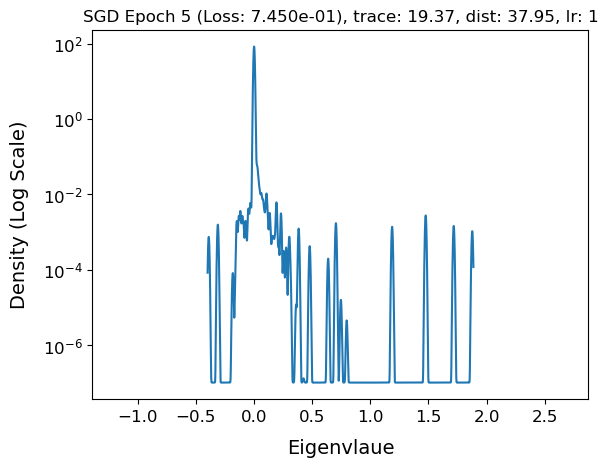

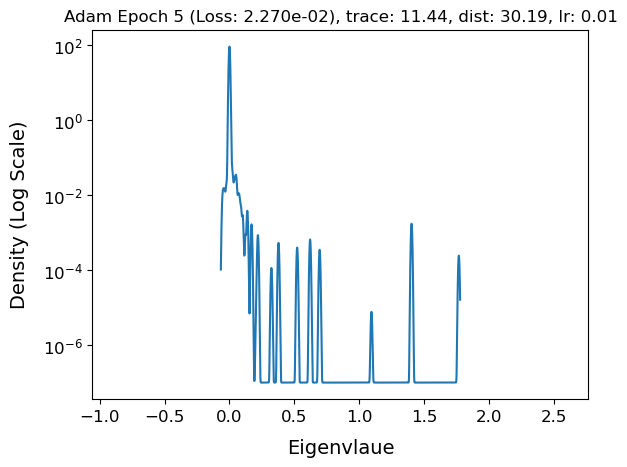

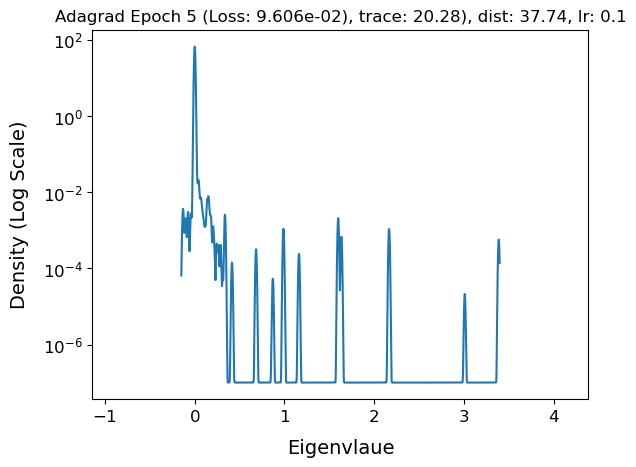

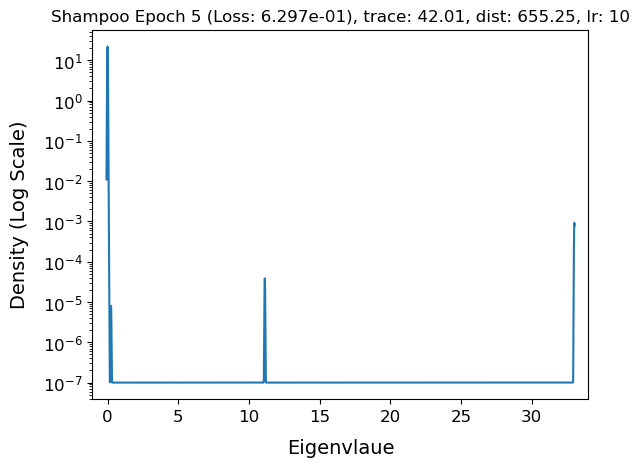

Epoch 6/30, Batch 1/32, Loss_SGD: 1.2501050233840942, Loss_Adam: 0.017138738185167313, Loss_Adagrad: 0.11873282492160797, Loss_Shampoo: 0.0
Epoch 6/30, Batch 2/32, Loss_SGD: 0.9622223973274231, Loss_Adam: 0.04124562442302704, Loss_Adagrad: 0.12866617739200592, Loss_Shampoo: 0.0
Epoch 6/30, Batch 3/32, Loss_SGD: 0.5915299654006958, Loss_Adam: 0.005498910788446665, Loss_Adagrad: 0.02154226042330265, Loss_Shampoo: 0.0
Epoch 6/30, Batch 4/32, Loss_SGD: 0.7210376262664795, Loss_Adam: 0.048522982746362686, Loss_Adagrad: 0.10565156489610672, Loss_Shampoo: 0.0
Epoch 6/30, Batch 5/32, Loss_SGD: 0.5372872948646545, Loss_Adam: 0.023691872134804726, Loss_Adagrad: 0.08241664618253708, Loss_Shampoo: 0.0
Epoch 6/30, Batch 6/32, Loss_SGD: 0.9480944275856018, Loss_Adam: 0.007588230073451996, Loss_Adagrad: 0.07285428792238235, Loss_Shampoo: 0.0
Epoch 6/30, Batch 7/32, Loss_SGD: 0.9978868961334229, Loss_Adam: 0.02275747060775757, Loss_Adagrad: 0.10712213814258575, Loss_Shampoo: 2.6258792877197266
Epoch 6

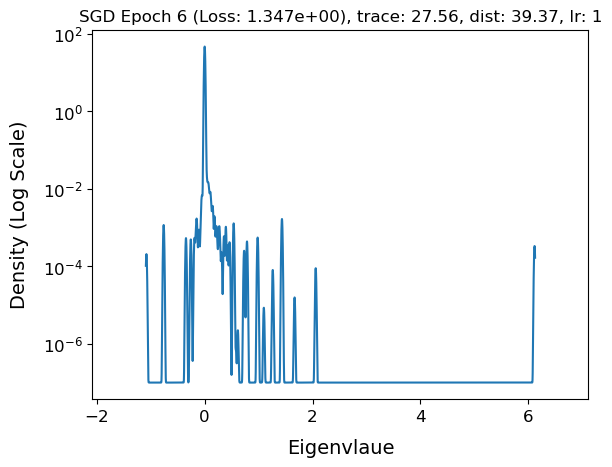

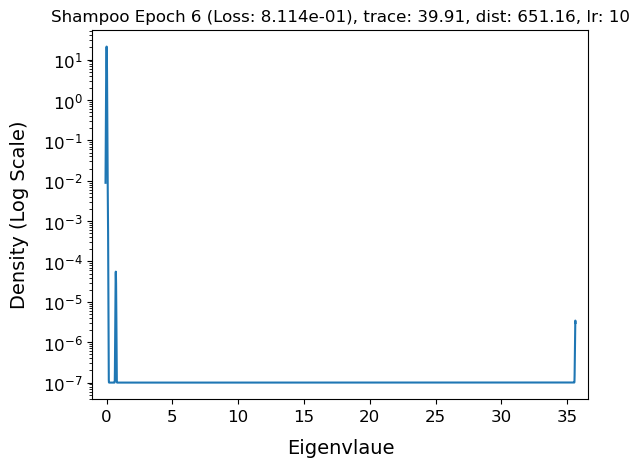

Epoch 7/30, Batch 1/32, Loss_SGD: 0.5166833996772766, Loss_Adam: 0.008623337373137474, Loss_Adagrad: 0.029175903648138046, Loss_Shampoo: 0.00015092644025571644
Epoch 7/30, Batch 2/32, Loss_SGD: 1.6842844486236572, Loss_Adam: 0.005280312616378069, Loss_Adagrad: 0.04210706800222397, Loss_Shampoo: 7.985679626464844
Epoch 7/30, Batch 3/32, Loss_SGD: 1.0878682136535645, Loss_Adam: 0.004679194651544094, Loss_Adagrad: 0.032470181584358215, Loss_Shampoo: 0.9288616180419922
Epoch 7/30, Batch 4/32, Loss_SGD: 1.1030908823013306, Loss_Adam: 0.009024135768413544, Loss_Adagrad: 0.044167984277009964, Loss_Shampoo: 0.0
Epoch 7/30, Batch 5/32, Loss_SGD: 0.9274477362632751, Loss_Adam: 0.02084035612642765, Loss_Adagrad: 0.0715794786810875, Loss_Shampoo: 0.0
Epoch 7/30, Batch 6/32, Loss_SGD: 0.5993111729621887, Loss_Adam: 0.016593340784311295, Loss_Adagrad: 0.06102374941110611, Loss_Shampoo: 0.0
Epoch 7/30, Batch 7/32, Loss_SGD: 0.8274848461151123, Loss_Adam: 0.0029994549695402384, Loss_Adagrad: 0.0397342

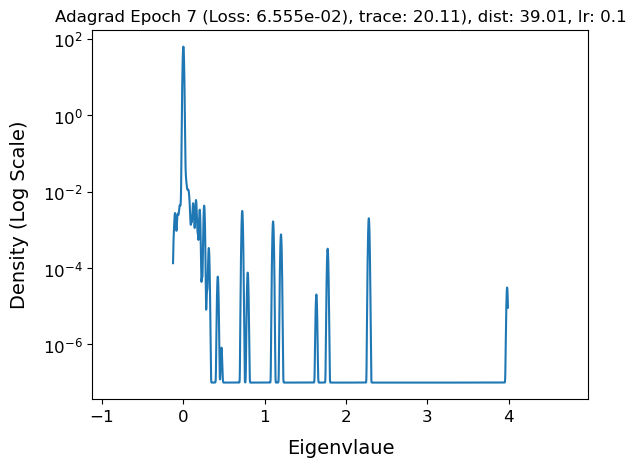

Epoch 8/30, Batch 1/32, Loss_SGD: 3.3589017391204834, Loss_Adam: 0.007733372505754232, Loss_Adagrad: 0.08087988942861557, Loss_Shampoo: 0.0
Epoch 8/30, Batch 2/32, Loss_SGD: 1.7509461641311646, Loss_Adam: 0.0031490810215473175, Loss_Adagrad: 0.03597342595458031, Loss_Shampoo: 0.0
Epoch 8/30, Batch 3/32, Loss_SGD: 1.970270037651062, Loss_Adam: 0.005394679494202137, Loss_Adagrad: 0.08950537443161011, Loss_Shampoo: 0.0
Epoch 8/30, Batch 4/32, Loss_SGD: 2.4170165061950684, Loss_Adam: 0.003847107058390975, Loss_Adagrad: 0.03277809917926788, Loss_Shampoo: 2.250997543334961
Epoch 8/30, Batch 5/32, Loss_SGD: 1.5212595462799072, Loss_Adam: 0.0028820724692195654, Loss_Adagrad: 0.030326763167977333, Loss_Shampoo: 0.0
Epoch 8/30, Batch 6/32, Loss_SGD: 1.2759360074996948, Loss_Adam: 0.004610114730894566, Loss_Adagrad: 0.03535883501172066, Loss_Shampoo: 0.0
Epoch 8/30, Batch 7/32, Loss_SGD: 1.4616659879684448, Loss_Adam: 0.0031566726975142956, Loss_Adagrad: 0.03951201215386391, Loss_Shampoo: 0.0
Epo

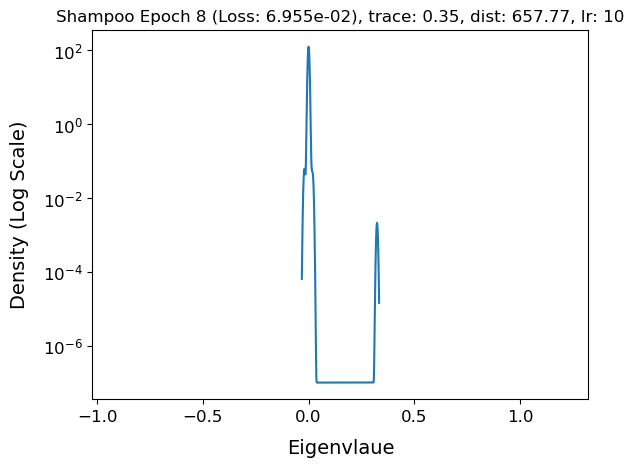

Epoch 9/30, Batch 1/32, Loss_SGD: 0.9980297684669495, Loss_Adam: 0.0021496897097676992, Loss_Adagrad: 0.024967709556221962, Loss_Shampoo: 0.0
Epoch 9/30, Batch 2/32, Loss_SGD: 0.988233208656311, Loss_Adam: 0.0038391142152249813, Loss_Adagrad: 0.03324555978178978, Loss_Shampoo: 0.0
Epoch 9/30, Batch 3/32, Loss_SGD: 0.6931851506233215, Loss_Adam: 0.002523216884583235, Loss_Adagrad: 0.01630883291363716, Loss_Shampoo: 0.0
Epoch 9/30, Batch 4/32, Loss_SGD: 1.005165934562683, Loss_Adam: 0.0033870087936520576, Loss_Adagrad: 0.03806805610656738, Loss_Shampoo: 0.0
Epoch 9/30, Batch 5/32, Loss_SGD: 0.9826843738555908, Loss_Adam: 0.0010733812814578414, Loss_Adagrad: 0.0183726716786623, Loss_Shampoo: 0.0
Epoch 9/30, Batch 6/32, Loss_SGD: 0.9695671796798706, Loss_Adam: 0.002224164782091975, Loss_Adagrad: 0.029802827164530754, Loss_Shampoo: 1.5727224349975586
Epoch 9/30, Batch 7/32, Loss_SGD: 0.9311603307723999, Loss_Adam: 0.0020735147409141064, Loss_Adagrad: 0.02969372645020485, Loss_Shampoo: 0.0
E

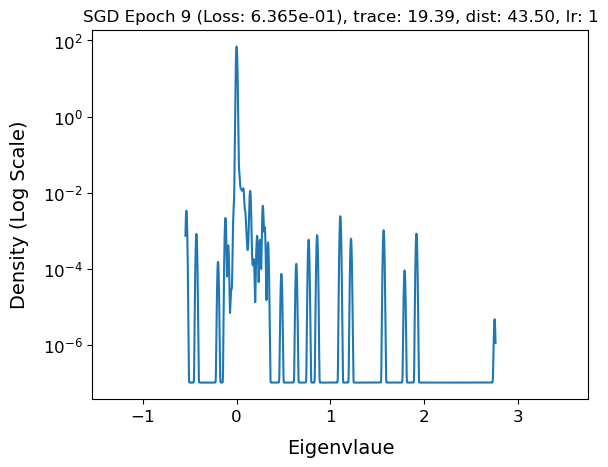

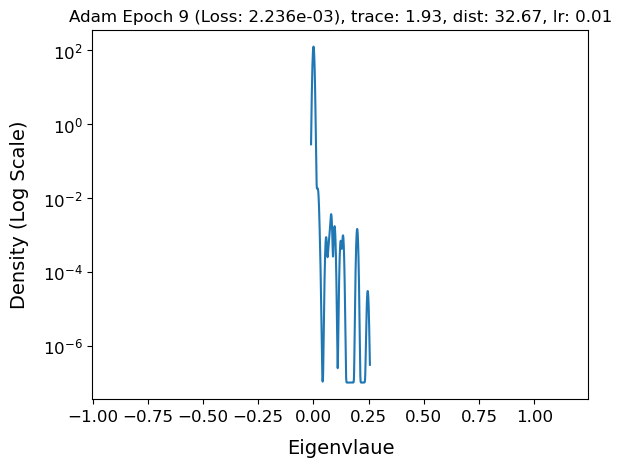

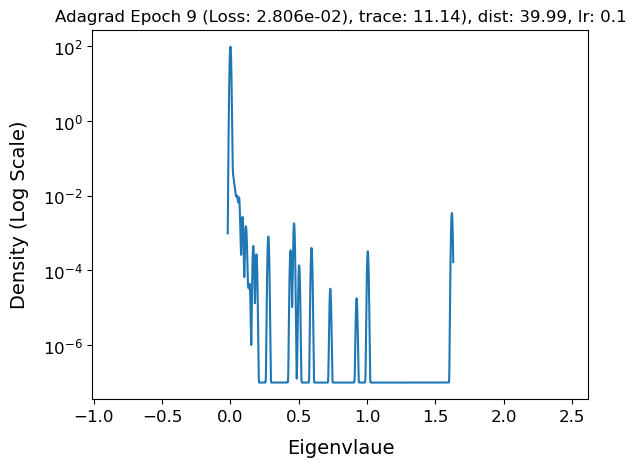

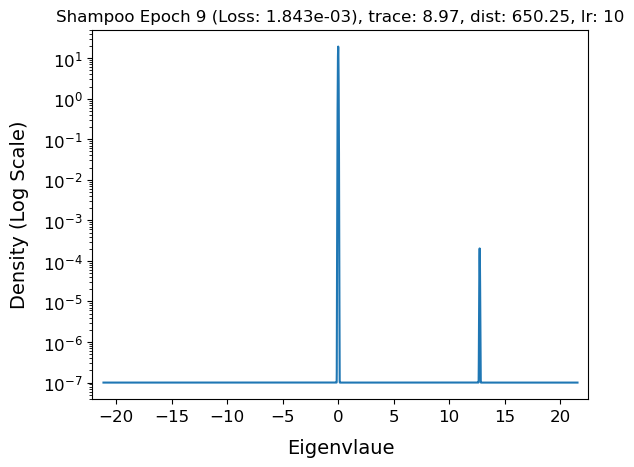

Epoch 10/30, Batch 1/32, Loss_SGD: 0.8139644861221313, Loss_Adam: 0.001110468409024179, Loss_Adagrad: 0.012668919749557972, Loss_Shampoo: 0.0
Epoch 10/30, Batch 2/32, Loss_SGD: 0.7128455638885498, Loss_Adam: 0.00488264812156558, Loss_Adagrad: 0.03179982677102089, Loss_Shampoo: 0.0
Epoch 10/30, Batch 3/32, Loss_SGD: 0.8847696185112, Loss_Adam: 0.002552345395088196, Loss_Adagrad: 0.034155212342739105, Loss_Shampoo: 0.0
Epoch 10/30, Batch 4/32, Loss_SGD: 0.6406773328781128, Loss_Adam: 0.0030796974897384644, Loss_Adagrad: 0.03210710361599922, Loss_Shampoo: 0.0
Epoch 10/30, Batch 5/32, Loss_SGD: 0.5723078846931458, Loss_Adam: 0.0037452776450663805, Loss_Adagrad: 0.03482072427868843, Loss_Shampoo: 0.0
Epoch 10/30, Batch 6/32, Loss_SGD: 0.5501768589019775, Loss_Adam: 0.0023424418177455664, Loss_Adagrad: 0.02060793898999691, Loss_Shampoo: 0.0
Epoch 10/30, Batch 7/32, Loss_SGD: 0.3068568706512451, Loss_Adam: 0.0009922479512169957, Loss_Adagrad: 0.012694941833615303, Loss_Shampoo: 0.0
Epoch 10/3

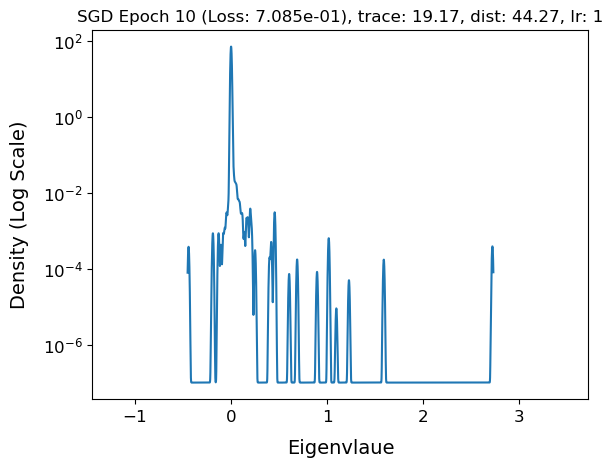

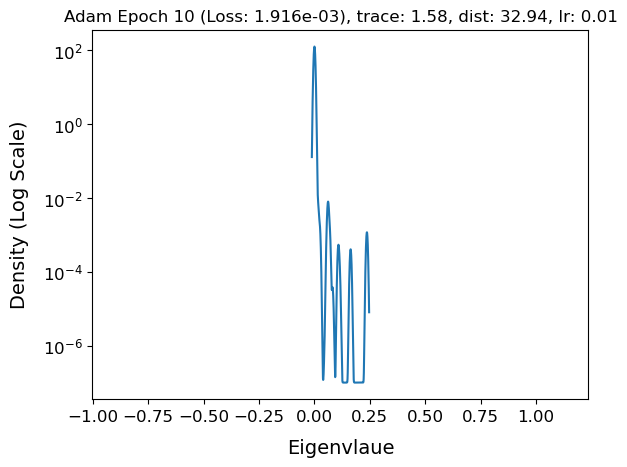

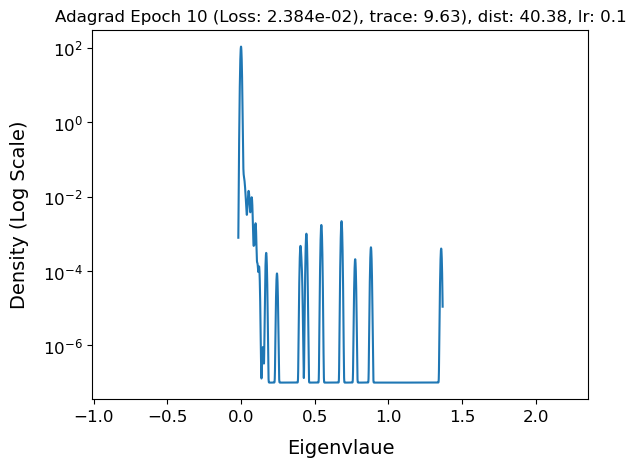

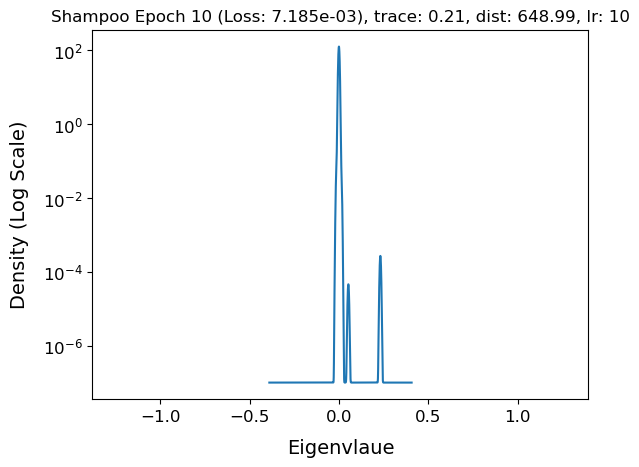

Epoch 11/30, Batch 1/32, Loss_SGD: 0.8939512968063354, Loss_Adam: 0.0011063024867326021, Loss_Adagrad: 0.01472218707203865, Loss_Shampoo: 0.0
Epoch 11/30, Batch 2/32, Loss_SGD: 0.6630065441131592, Loss_Adam: 0.0009241437073796988, Loss_Adagrad: 0.013258627615869045, Loss_Shampoo: 0.0
Epoch 11/30, Batch 3/32, Loss_SGD: 0.5531507134437561, Loss_Adam: 0.00352374161593616, Loss_Adagrad: 0.028964674100279808, Loss_Shampoo: 0.0
Epoch 11/30, Batch 4/32, Loss_SGD: 0.3889952600002289, Loss_Adam: 0.001090383855625987, Loss_Adagrad: 0.01581043377518654, Loss_Shampoo: 0.0
Epoch 11/30, Batch 5/32, Loss_SGD: 0.6031816005706787, Loss_Adam: 0.003859107382595539, Loss_Adagrad: 0.03115222416818142, Loss_Shampoo: 5.850304296473041e-05
Epoch 11/30, Batch 6/32, Loss_SGD: 0.8143253326416016, Loss_Adam: 0.003941657952964306, Loss_Adagrad: 0.03496718406677246, Loss_Shampoo: 0.0
Epoch 11/30, Batch 7/32, Loss_SGD: 0.34435132145881653, Loss_Adam: 0.002275696024298668, Loss_Adagrad: 0.023938022553920746, Loss_Sha

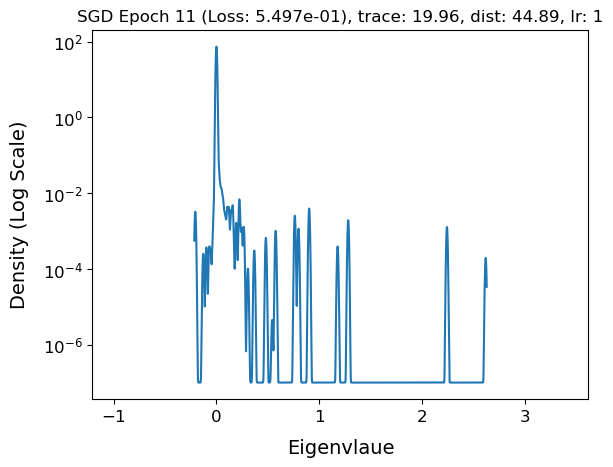

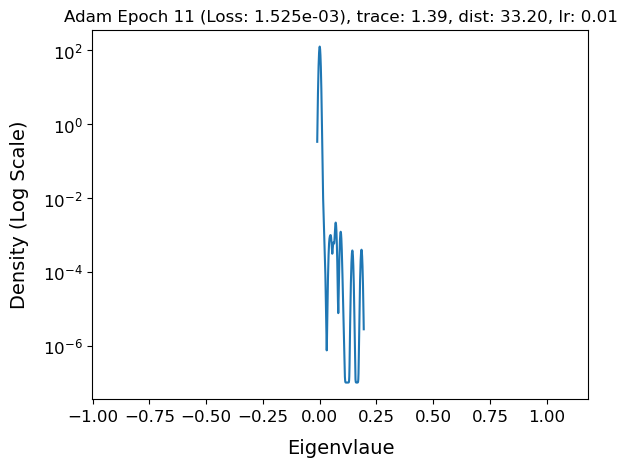

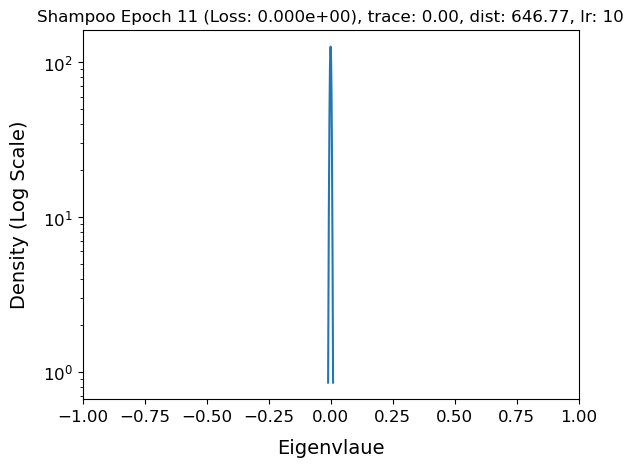

Epoch 12/30, Batch 1/32, Loss_SGD: 0.32029348611831665, Loss_Adam: 0.0014757236931473017, Loss_Adagrad: 0.015133986249566078, Loss_Shampoo: 0.0
Epoch 12/30, Batch 2/32, Loss_SGD: 0.2173546701669693, Loss_Adam: 0.0008391077280975878, Loss_Adagrad: 0.010341004468500614, Loss_Shampoo: 0.0
Epoch 12/30, Batch 3/32, Loss_SGD: 0.2798278331756592, Loss_Adam: 0.0023401041980832815, Loss_Adagrad: 0.060586925595998764, Loss_Shampoo: 0.0
Epoch 12/30, Batch 4/32, Loss_SGD: 0.30455857515335083, Loss_Adam: 0.0018281096126884222, Loss_Adagrad: 0.02217784896492958, Loss_Shampoo: 0.0
Epoch 12/30, Batch 5/32, Loss_SGD: 0.34220170974731445, Loss_Adam: 0.0012570030521601439, Loss_Adagrad: 0.017625028267502785, Loss_Shampoo: 0.0
Epoch 12/30, Batch 6/32, Loss_SGD: 0.42541271448135376, Loss_Adam: 0.001101747271604836, Loss_Adagrad: 0.012473695911467075, Loss_Shampoo: 0.0
Epoch 12/30, Batch 7/32, Loss_SGD: 1.3031810522079468, Loss_Adam: 0.0014878978254273534, Loss_Adagrad: 0.018436700105667114, Loss_Shampoo: 0

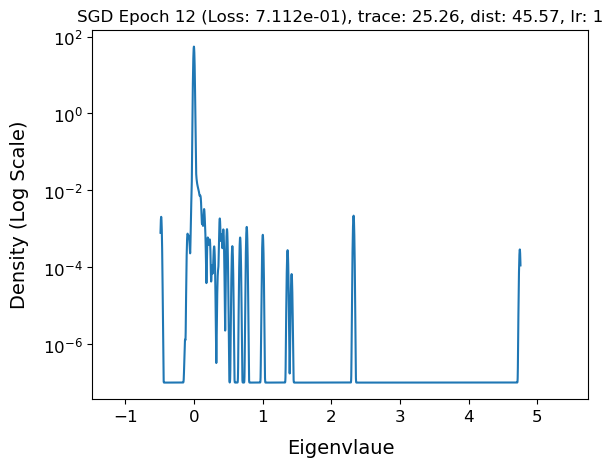

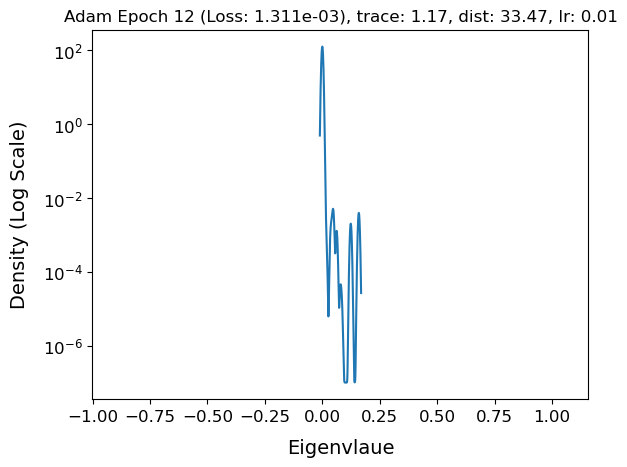

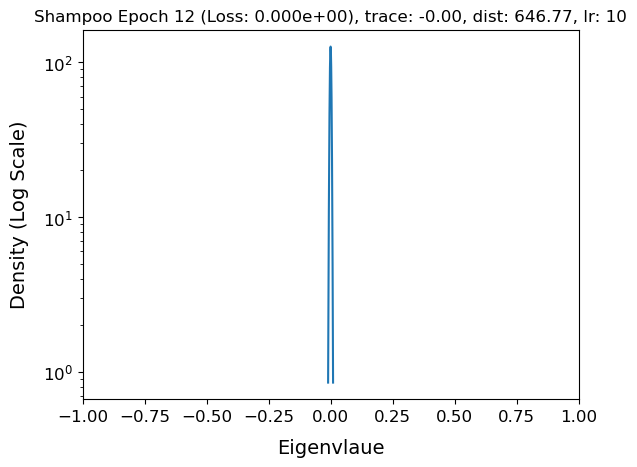

Epoch 13/30, Batch 1/32, Loss_SGD: 0.4112436771392822, Loss_Adam: 0.0008492901688441634, Loss_Adagrad: 0.00947063323110342, Loss_Shampoo: 0.0
Epoch 13/30, Batch 2/32, Loss_SGD: 0.2676481008529663, Loss_Adam: 0.0018288102000951767, Loss_Adagrad: 0.025744378566741943, Loss_Shampoo: 0.0
Epoch 13/30, Batch 3/32, Loss_SGD: 0.11775163561105728, Loss_Adam: 0.0013474306324496865, Loss_Adagrad: 0.011241637170314789, Loss_Shampoo: 0.0
Epoch 13/30, Batch 4/32, Loss_SGD: 0.20041407644748688, Loss_Adam: 0.0006930496310815215, Loss_Adagrad: 0.013022519648075104, Loss_Shampoo: 0.0
Epoch 13/30, Batch 5/32, Loss_SGD: 0.22561189532279968, Loss_Adam: 0.0015762142138555646, Loss_Adagrad: 0.0437251441180706, Loss_Shampoo: 0.0
Epoch 13/30, Batch 6/32, Loss_SGD: 0.3622620701789856, Loss_Adam: 0.0011732258135452867, Loss_Adagrad: 0.013118742033839226, Loss_Shampoo: 0.0
Epoch 13/30, Batch 7/32, Loss_SGD: 0.28235116600990295, Loss_Adam: 0.0013842962216585875, Loss_Adagrad: 0.02059970423579216, Loss_Shampoo: 0.0

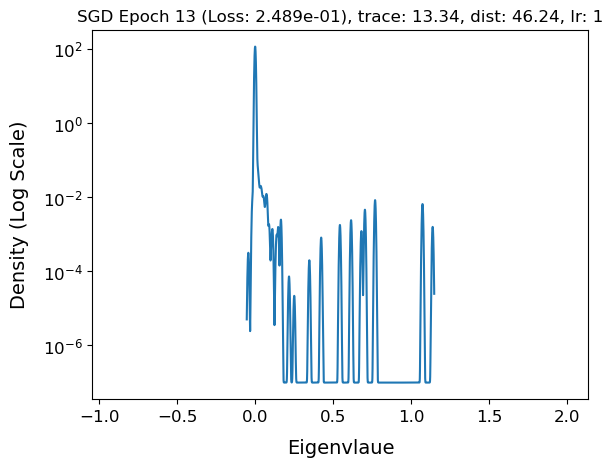

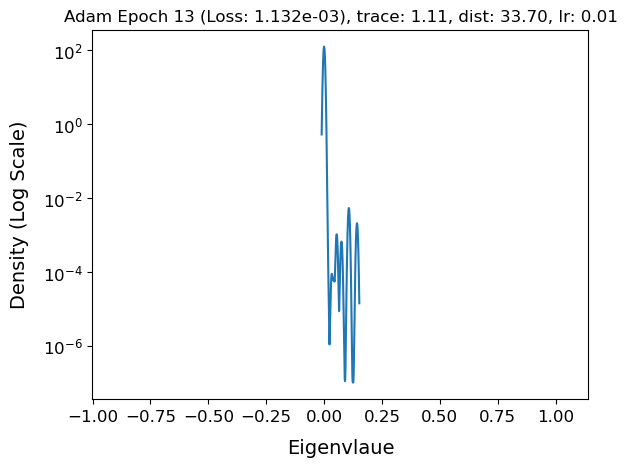

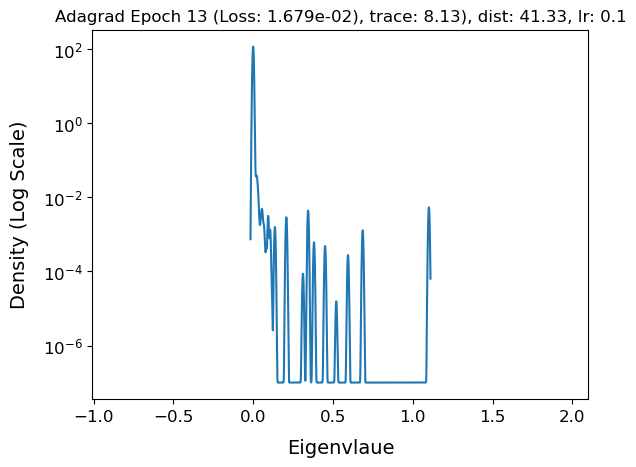

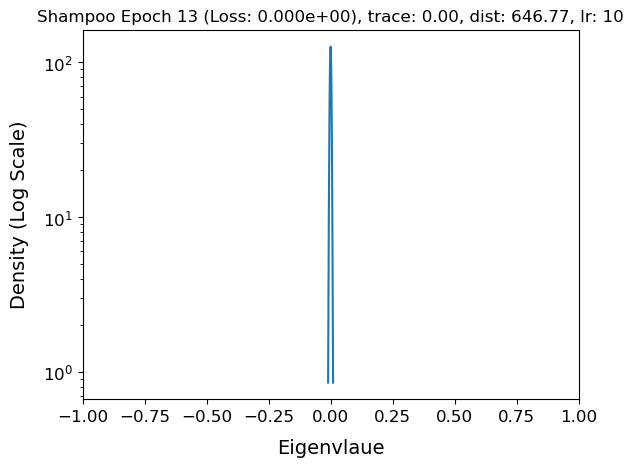

Epoch 14/30, Batch 1/32, Loss_SGD: 0.32832545042037964, Loss_Adam: 0.0015510802622884512, Loss_Adagrad: 0.01838010922074318, Loss_Shampoo: 0.0
Epoch 14/30, Batch 2/32, Loss_SGD: 0.22537767887115479, Loss_Adam: 0.0007324509788304567, Loss_Adagrad: 0.01042515691369772, Loss_Shampoo: 0.0
Epoch 14/30, Batch 3/32, Loss_SGD: 0.20029906928539276, Loss_Adam: 0.0012456264812499285, Loss_Adagrad: 0.00853821448981762, Loss_Shampoo: 0.0
Epoch 14/30, Batch 4/32, Loss_SGD: 0.22267775237560272, Loss_Adam: 0.0009746956056915224, Loss_Adagrad: 0.015710625797510147, Loss_Shampoo: 0.0
Epoch 14/30, Batch 5/32, Loss_SGD: 0.3658072352409363, Loss_Adam: 0.0015711929881945252, Loss_Adagrad: 0.016985176131129265, Loss_Shampoo: 0.0
Epoch 14/30, Batch 6/32, Loss_SGD: 0.15141922235488892, Loss_Adam: 0.0007813452393747866, Loss_Adagrad: 0.010775672271847725, Loss_Shampoo: 0.0
Epoch 14/30, Batch 7/32, Loss_SGD: 0.196944460272789, Loss_Adam: 0.0007787226932123303, Loss_Adagrad: 0.005432234611362219, Loss_Shampoo: 0.

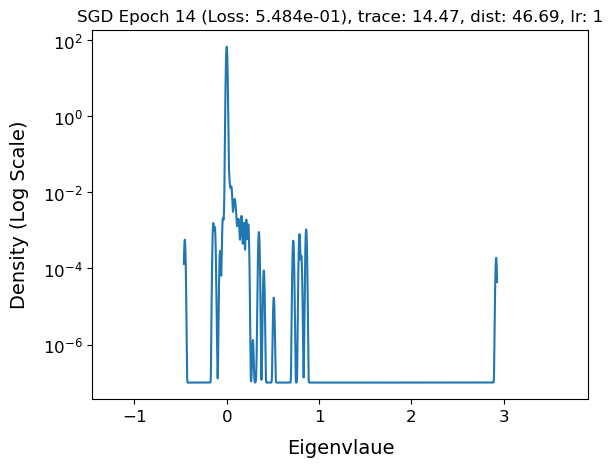

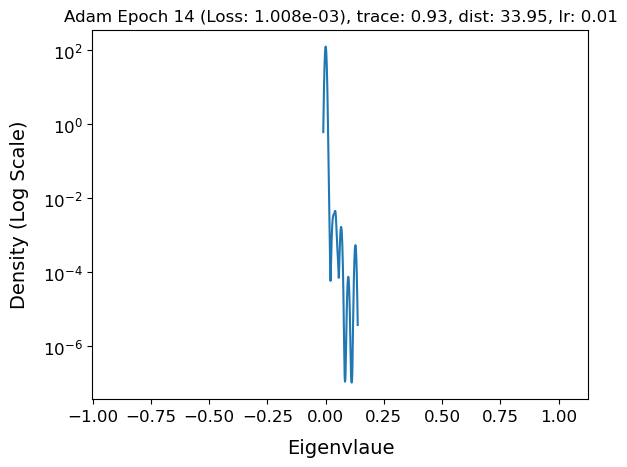

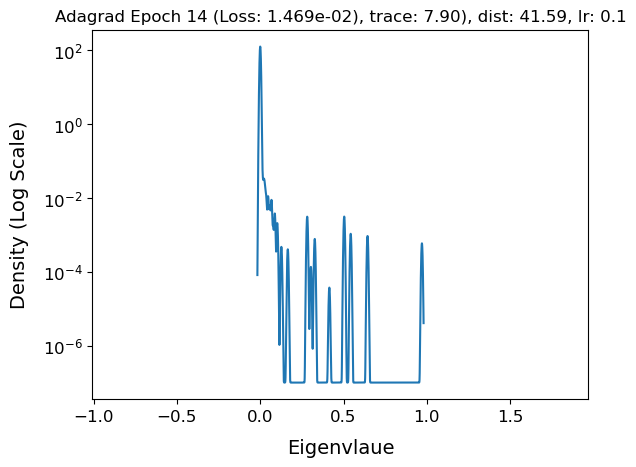

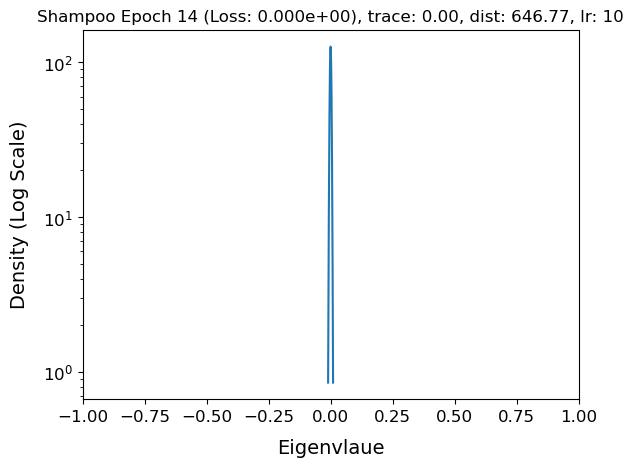

Epoch 15/30, Batch 1/32, Loss_SGD: 0.4004407823085785, Loss_Adam: 0.0011541711864992976, Loss_Adagrad: 0.011820903979241848, Loss_Shampoo: 0.0
Epoch 15/30, Batch 2/32, Loss_SGD: 0.10456833243370056, Loss_Adam: 0.0006622948567382991, Loss_Adagrad: 0.00851830281317234, Loss_Shampoo: 0.0
Epoch 15/30, Batch 3/32, Loss_SGD: 0.05930251255631447, Loss_Adam: 0.0004568940494209528, Loss_Adagrad: 0.006167395506054163, Loss_Shampoo: 0.0
Epoch 15/30, Batch 4/32, Loss_SGD: 0.3328166604042053, Loss_Adam: 0.0009299427038058639, Loss_Adagrad: 0.014372499659657478, Loss_Shampoo: 0.0
Epoch 15/30, Batch 5/32, Loss_SGD: 0.12693828344345093, Loss_Adam: 0.0009112455882132053, Loss_Adagrad: 0.011209746822714806, Loss_Shampoo: 0.0
Epoch 15/30, Batch 6/32, Loss_SGD: 0.16806912422180176, Loss_Adam: 0.0009074973058886826, Loss_Adagrad: 0.010670002549886703, Loss_Shampoo: 0.0
Epoch 15/30, Batch 7/32, Loss_SGD: 0.3512255549430847, Loss_Adam: 0.0013830384705215693, Loss_Adagrad: 0.015879424288868904, Loss_Shampoo: 

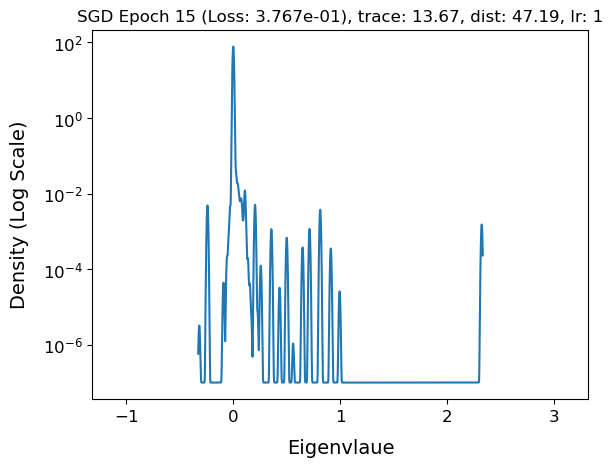

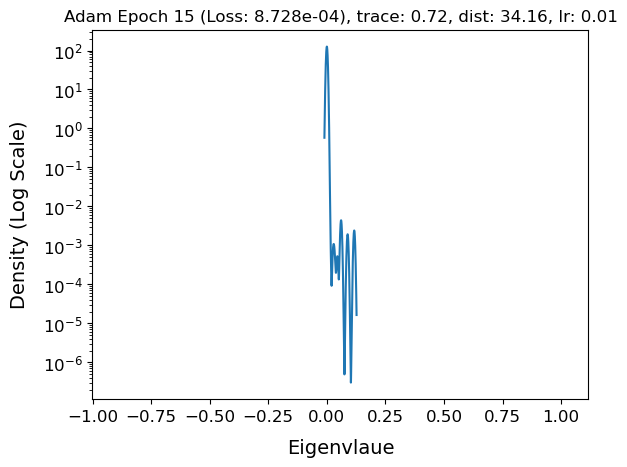

Epoch 16/30, Batch 1/32, Loss_SGD: 0.2693611681461334, Loss_Adam: 0.0007584331324324012, Loss_Adagrad: 0.01406007632613182, Loss_Shampoo: 0.0
Epoch 16/30, Batch 2/32, Loss_SGD: 0.19165807962417603, Loss_Adam: 0.001411782344803214, Loss_Adagrad: 0.014212697744369507, Loss_Shampoo: 0.0
Epoch 16/30, Batch 3/32, Loss_SGD: 0.23561254143714905, Loss_Adam: 0.0010608593001961708, Loss_Adagrad: 0.017697345465421677, Loss_Shampoo: 0.0
Epoch 16/30, Batch 4/32, Loss_SGD: 0.3207884728908539, Loss_Adam: 0.00134084967430681, Loss_Adagrad: 0.02094636857509613, Loss_Shampoo: 0.0
Epoch 16/30, Batch 5/32, Loss_SGD: 0.06131931021809578, Loss_Adam: 0.0003541952755767852, Loss_Adagrad: 0.007078628055751324, Loss_Shampoo: 0.0
Epoch 16/30, Batch 6/32, Loss_SGD: 0.15065978467464447, Loss_Adam: 0.0011776448227465153, Loss_Adagrad: 0.01427438110113144, Loss_Shampoo: 0.0
Epoch 16/30, Batch 7/32, Loss_SGD: 0.0937127098441124, Loss_Adam: 0.0007929448620416224, Loss_Adagrad: 0.011972005479037762, Loss_Shampoo: 0.0
E

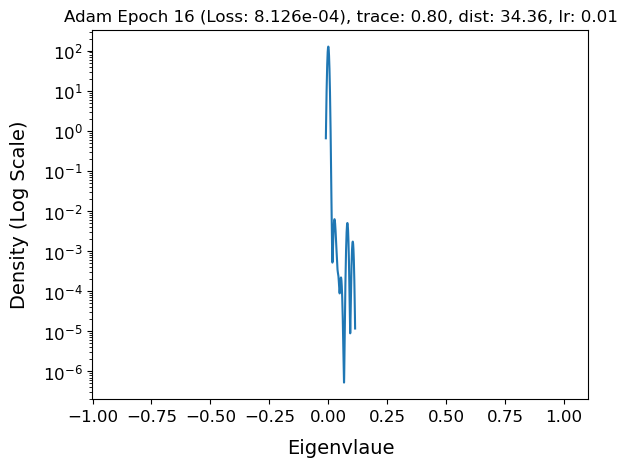

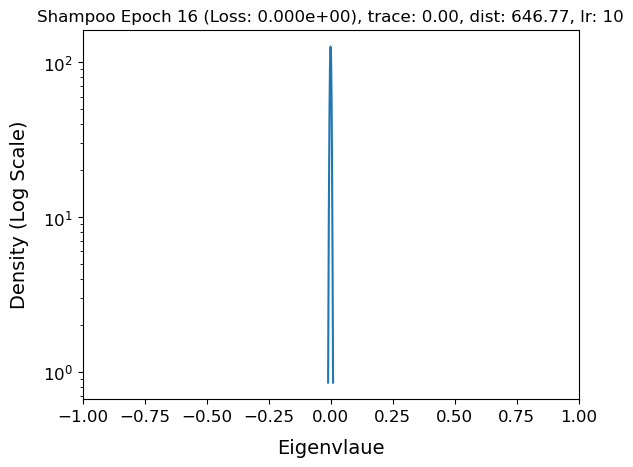

Epoch 17/30, Batch 1/32, Loss_SGD: 0.7081477046012878, Loss_Adam: 0.0009154558647423983, Loss_Adagrad: 0.01396331749856472, Loss_Shampoo: 0.0
Epoch 17/30, Batch 2/32, Loss_SGD: 0.13525770604610443, Loss_Adam: 0.0005469383904710412, Loss_Adagrad: 0.010841677896678448, Loss_Shampoo: 0.0
Epoch 17/30, Batch 3/32, Loss_SGD: 0.17081813514232635, Loss_Adam: 0.0008893776684999466, Loss_Adagrad: 0.007948151789605618, Loss_Shampoo: 0.0
Epoch 17/30, Batch 4/32, Loss_SGD: 0.18178951740264893, Loss_Adam: 0.0008559050038456917, Loss_Adagrad: 0.011892609298229218, Loss_Shampoo: 0.0
Epoch 17/30, Batch 5/32, Loss_SGD: 0.5052459239959717, Loss_Adam: 0.0005555200623348355, Loss_Adagrad: 0.004593909718096256, Loss_Shampoo: 0.0
Epoch 17/30, Batch 6/32, Loss_SGD: 0.046652015298604965, Loss_Adam: 0.0008537106332369149, Loss_Adagrad: 0.0091606630012393, Loss_Shampoo: 0.0
Epoch 17/30, Batch 7/32, Loss_SGD: 0.10938407480716705, Loss_Adam: 0.0011732324492186308, Loss_Adagrad: 0.010962601751089096, Loss_Shampoo: 

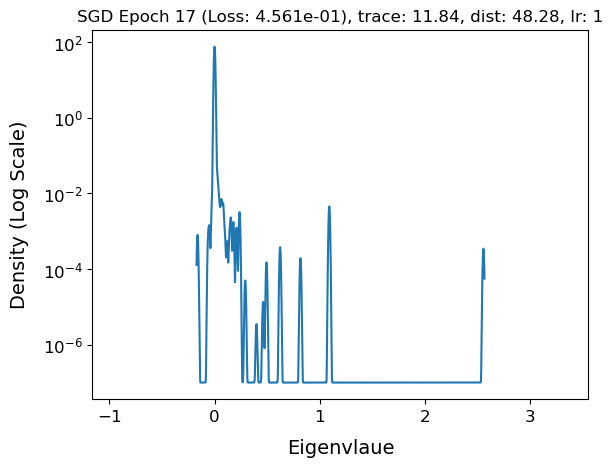

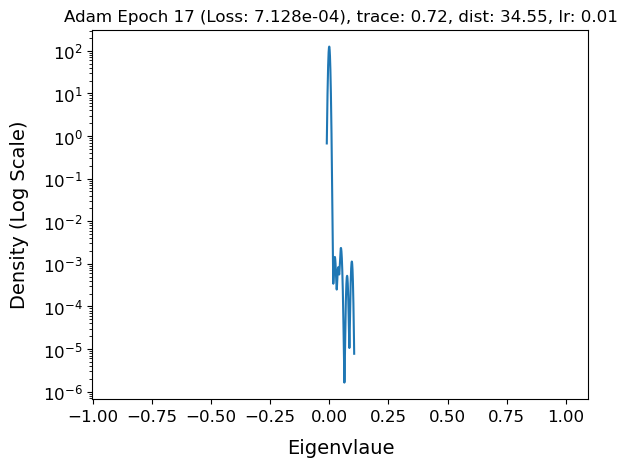

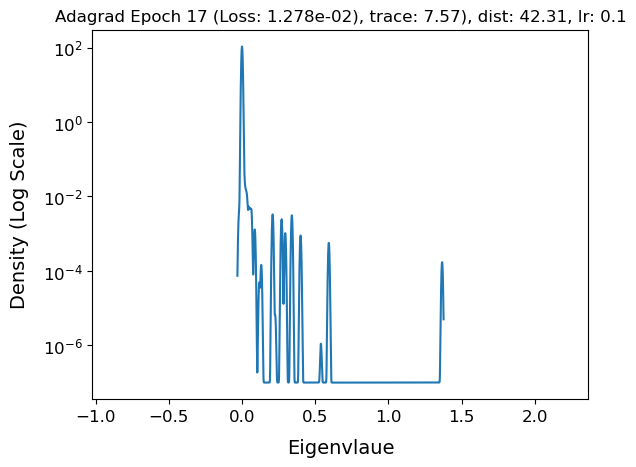

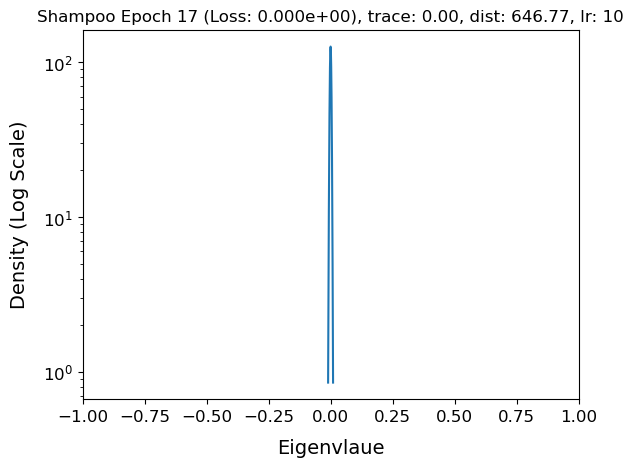

Epoch 18/30, Batch 1/32, Loss_SGD: 0.46043261885643005, Loss_Adam: 0.0007965019322000444, Loss_Adagrad: 0.01131202932447195, Loss_Shampoo: 0.0
Epoch 18/30, Batch 2/32, Loss_SGD: 0.3984256088733673, Loss_Adam: 0.0009677605121396482, Loss_Adagrad: 0.013867136090993881, Loss_Shampoo: 0.0
Epoch 18/30, Batch 3/32, Loss_SGD: 0.3784889578819275, Loss_Adam: 0.0005940569099038839, Loss_Adagrad: 0.00906175933778286, Loss_Shampoo: 0.0
Epoch 18/30, Batch 4/32, Loss_SGD: 0.30457791686058044, Loss_Adam: 0.0006058480939827859, Loss_Adagrad: 0.013077833689749241, Loss_Shampoo: 0.0
Epoch 18/30, Batch 5/32, Loss_SGD: 0.18976297974586487, Loss_Adam: 0.0002866135910153389, Loss_Adagrad: 0.0036560865119099617, Loss_Shampoo: 0.0
Epoch 18/30, Batch 6/32, Loss_SGD: 0.8030859231948853, Loss_Adam: 0.0008548086043447256, Loss_Adagrad: 0.013374585658311844, Loss_Shampoo: 0.0
Epoch 18/30, Batch 7/32, Loss_SGD: 0.8178966641426086, Loss_Adam: 0.0007763977046124637, Loss_Adagrad: 0.006650248076766729, Loss_Shampoo: 0

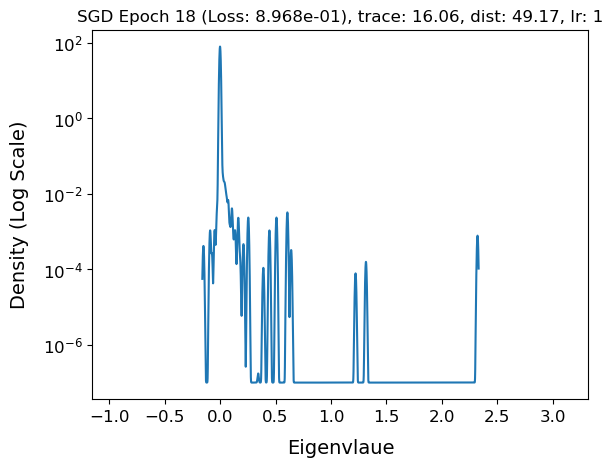

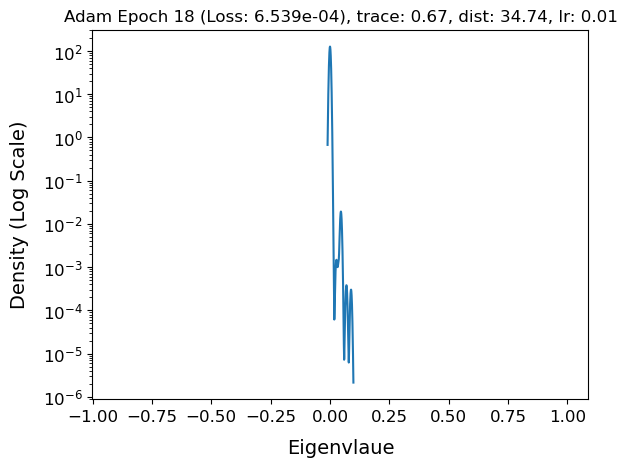

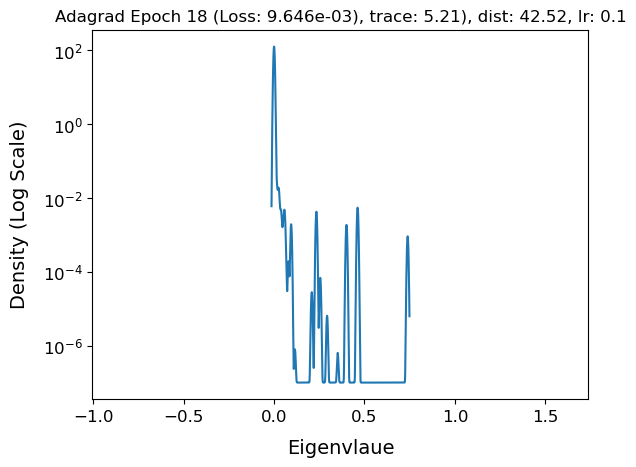

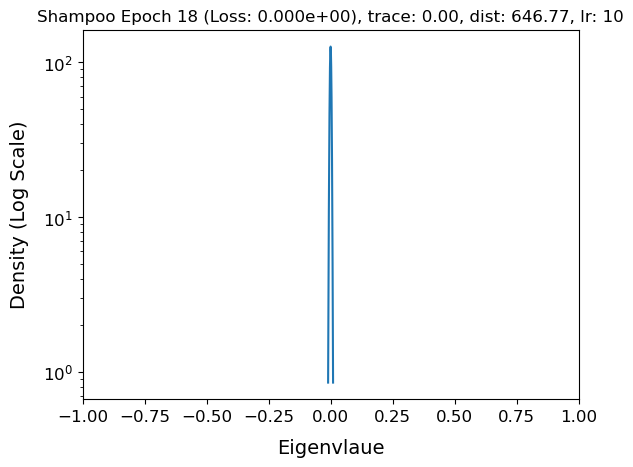

Epoch 19/30, Batch 1/32, Loss_SGD: 0.6347175240516663, Loss_Adam: 0.0007885552477091551, Loss_Adagrad: 0.008903739973902702, Loss_Shampoo: 0.0
Epoch 19/30, Batch 2/32, Loss_SGD: 1.1219606399536133, Loss_Adam: 0.00089349813060835, Loss_Adagrad: 0.010185372084379196, Loss_Shampoo: 0.0
Epoch 19/30, Batch 3/32, Loss_SGD: 0.7008118629455566, Loss_Adam: 0.0009832506766542792, Loss_Adagrad: 0.015095986425876617, Loss_Shampoo: 0.0
Epoch 19/30, Batch 4/32, Loss_SGD: 0.8661319017410278, Loss_Adam: 0.0006264301482588053, Loss_Adagrad: 0.005494872108101845, Loss_Shampoo: 0.0
Epoch 19/30, Batch 5/32, Loss_SGD: 1.0370813608169556, Loss_Adam: 0.00026761266053654253, Loss_Adagrad: 0.0041817473247647285, Loss_Shampoo: 0.0
Epoch 19/30, Batch 6/32, Loss_SGD: 0.7928028106689453, Loss_Adam: 0.0002174267137888819, Loss_Adagrad: 0.0023296268191188574, Loss_Shampoo: 0.0
Epoch 19/30, Batch 7/32, Loss_SGD: 0.8931294679641724, Loss_Adam: 0.0006637816550210118, Loss_Adagrad: 0.00885109044611454, Loss_Shampoo: 0.0

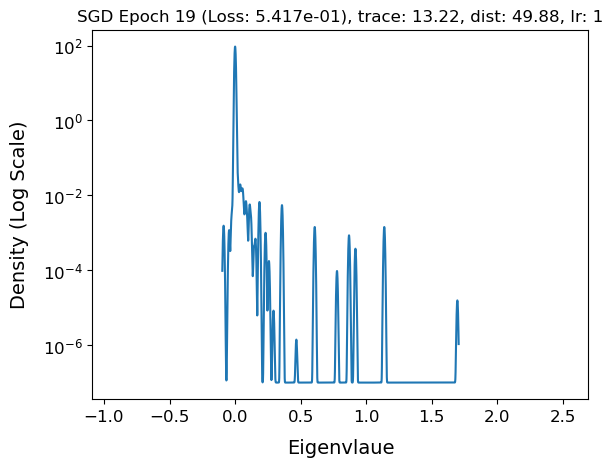

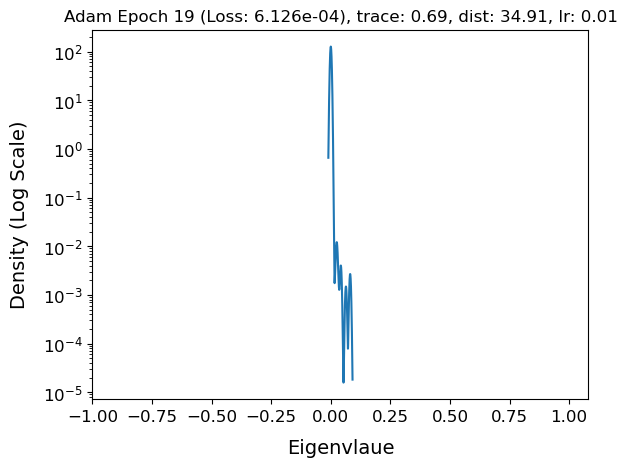

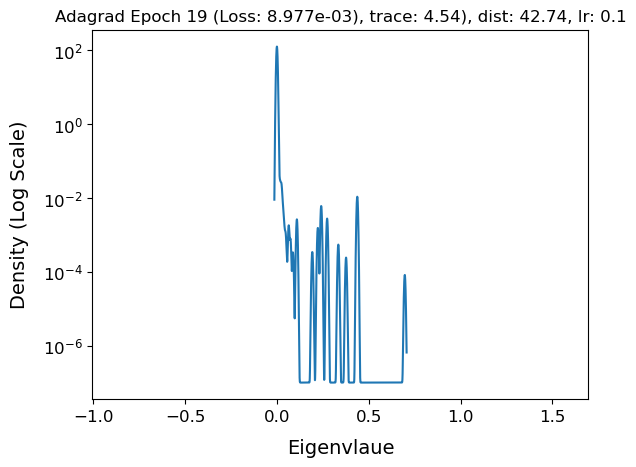

Epoch 20/30, Batch 1/32, Loss_SGD: 0.7209635376930237, Loss_Adam: 0.00045660469913855195, Loss_Adagrad: 0.005045142024755478, Loss_Shampoo: 0.0
Epoch 20/30, Batch 2/32, Loss_SGD: 0.8867045044898987, Loss_Adam: 0.0004902427899651229, Loss_Adagrad: 0.006840358953922987, Loss_Shampoo: 0.0
Epoch 20/30, Batch 3/32, Loss_SGD: 0.23449726402759552, Loss_Adam: 0.00043960020411759615, Loss_Adagrad: 0.005979024805128574, Loss_Shampoo: 0.0
Epoch 20/30, Batch 4/32, Loss_SGD: 0.3854106366634369, Loss_Adam: 0.0009058723808266222, Loss_Adagrad: 0.014078132808208466, Loss_Shampoo: 0.0
Epoch 20/30, Batch 5/32, Loss_SGD: 0.4024227261543274, Loss_Adam: 0.00011677433212753385, Loss_Adagrad: 0.0022514432203024626, Loss_Shampoo: 0.0
Epoch 20/30, Batch 6/32, Loss_SGD: 0.6094632744789124, Loss_Adam: 0.0009857192635536194, Loss_Adagrad: 0.007092983927577734, Loss_Shampoo: 0.0
Epoch 20/30, Batch 7/32, Loss_SGD: 0.2626289427280426, Loss_Adam: 0.0003624343080446124, Loss_Adagrad: 0.004339107312262058, Loss_Shampoo

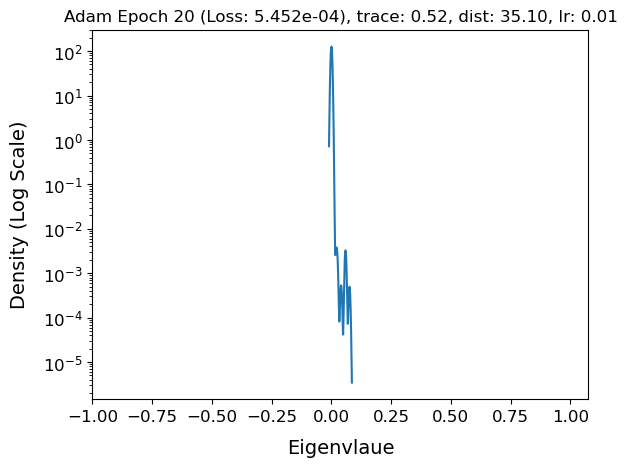

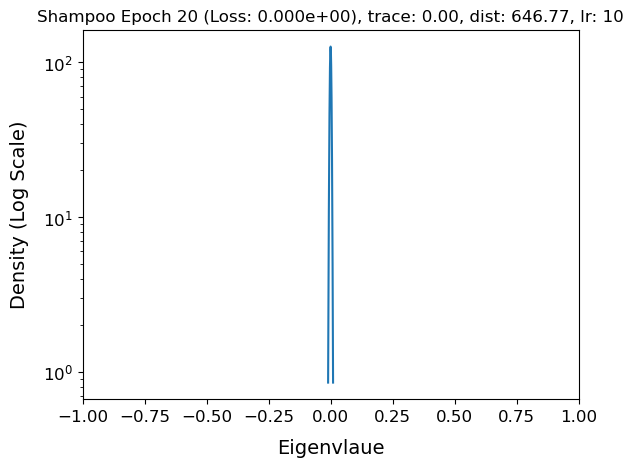

Epoch 21/30, Batch 1/32, Loss_SGD: 0.39155861735343933, Loss_Adam: 0.00024182145716622472, Loss_Adagrad: 0.0034576845355331898, Loss_Shampoo: 0.0
Epoch 21/30, Batch 2/32, Loss_SGD: 0.8191561698913574, Loss_Adam: 0.000751664221752435, Loss_Adagrad: 0.025660337880253792, Loss_Shampoo: 0.0
Epoch 21/30, Batch 3/32, Loss_SGD: 0.35587388277053833, Loss_Adam: 0.0008324631489813328, Loss_Adagrad: 0.011296718381345272, Loss_Shampoo: 0.0
Epoch 21/30, Batch 4/32, Loss_SGD: 0.22996865212917328, Loss_Adam: 0.00045991374645382166, Loss_Adagrad: 0.004676447249948978, Loss_Shampoo: 0.0
Epoch 21/30, Batch 5/32, Loss_SGD: 0.08956161886453629, Loss_Adam: 0.00023585243616253138, Loss_Adagrad: 0.005007889587432146, Loss_Shampoo: 0.0
Epoch 21/30, Batch 6/32, Loss_SGD: 0.3437941372394562, Loss_Adam: 0.0006111342227086425, Loss_Adagrad: 0.00547470897436142, Loss_Shampoo: 0.0
Epoch 21/30, Batch 7/32, Loss_SGD: 0.1688651144504547, Loss_Adam: 0.0008182812598533928, Loss_Adagrad: 0.015721620991826057, Loss_Shampo

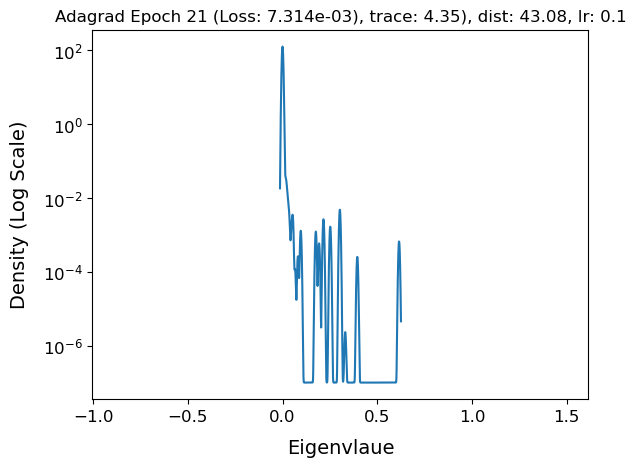

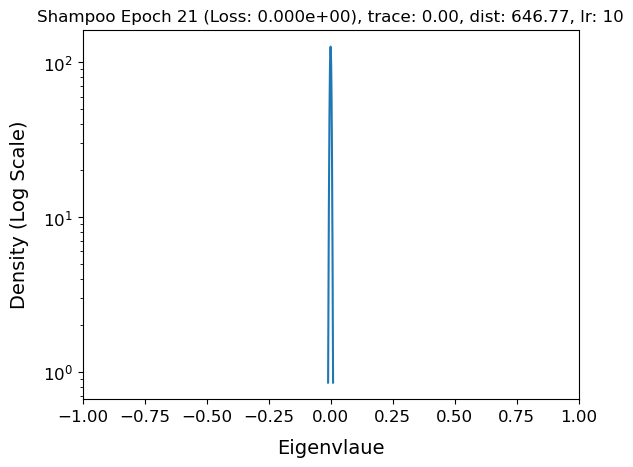

Epoch 22/30, Batch 1/32, Loss_SGD: 0.16847145557403564, Loss_Adam: 0.0005057128728367388, Loss_Adagrad: 0.00794463325291872, Loss_Shampoo: 0.0
Epoch 22/30, Batch 2/32, Loss_SGD: 0.18402691185474396, Loss_Adam: 0.00020801022765226662, Loss_Adagrad: 0.002999085932970047, Loss_Shampoo: 0.0
Epoch 22/30, Batch 3/32, Loss_SGD: 0.34692564606666565, Loss_Adam: 0.00046852408559061587, Loss_Adagrad: 0.010945969261229038, Loss_Shampoo: 0.0
Epoch 22/30, Batch 4/32, Loss_SGD: 0.21353934705257416, Loss_Adam: 0.0006094888085499406, Loss_Adagrad: 0.009029695764183998, Loss_Shampoo: 0.0
Epoch 22/30, Batch 5/32, Loss_SGD: 0.23836788535118103, Loss_Adam: 0.0006074047414585948, Loss_Adagrad: 0.005860559642314911, Loss_Shampoo: 0.0
Epoch 22/30, Batch 6/32, Loss_SGD: 0.42191916704177856, Loss_Adam: 0.0005244986386969686, Loss_Adagrad: 0.006914480589330196, Loss_Shampoo: 0.0
Epoch 22/30, Batch 7/32, Loss_SGD: 0.26502636075019836, Loss_Adam: 0.0005016685463488102, Loss_Adagrad: 0.008692625910043716, Loss_Sham

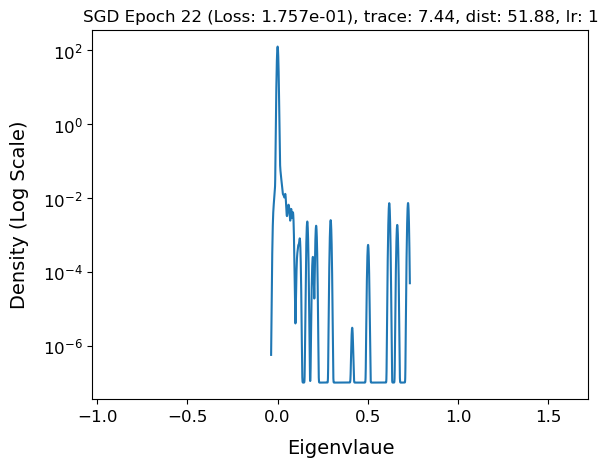

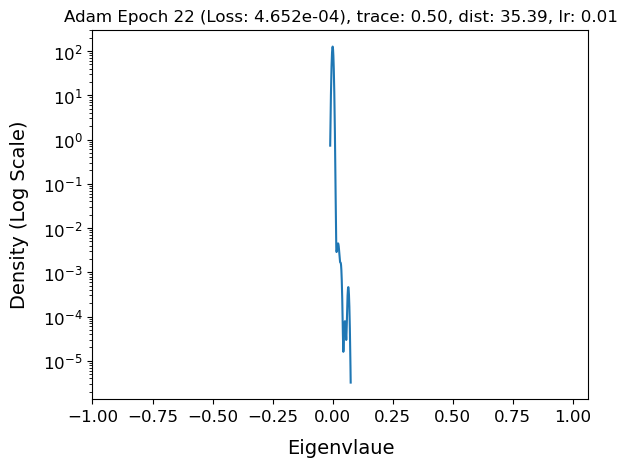

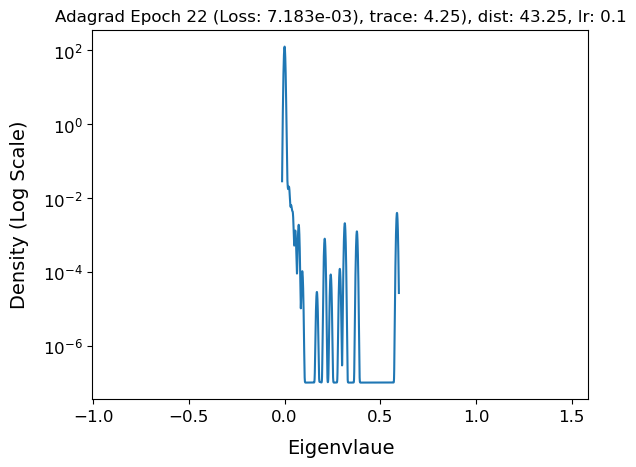

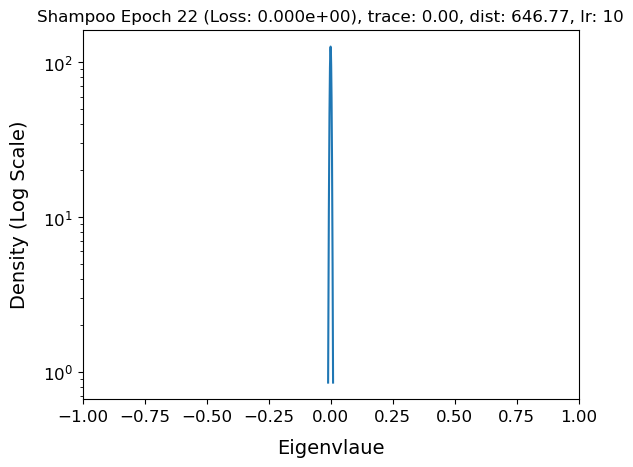

Epoch 23/30, Batch 1/32, Loss_SGD: 0.3892322778701782, Loss_Adam: 0.0004947325214743614, Loss_Adagrad: 0.007272904273122549, Loss_Shampoo: 0.0
Epoch 23/30, Batch 2/32, Loss_SGD: 0.10893917083740234, Loss_Adam: 0.0004943149397149682, Loss_Adagrad: 0.005698138382285833, Loss_Shampoo: 0.0
Epoch 23/30, Batch 3/32, Loss_SGD: 0.34118136763572693, Loss_Adam: 0.0010505970567464828, Loss_Adagrad: 0.013520166277885437, Loss_Shampoo: 0.0
Epoch 23/30, Batch 4/32, Loss_SGD: 0.04379525035619736, Loss_Adam: 0.00032809749245643616, Loss_Adagrad: 0.00539321918040514, Loss_Shampoo: 0.0
Epoch 23/30, Batch 5/32, Loss_SGD: 0.09353412687778473, Loss_Adam: 0.0002549793280195445, Loss_Adagrad: 0.003780126105993986, Loss_Shampoo: 0.0
Epoch 23/30, Batch 6/32, Loss_SGD: 0.08156518638134003, Loss_Adam: 0.00045513719669543207, Loss_Adagrad: 0.008215047419071198, Loss_Shampoo: 0.0
Epoch 23/30, Batch 7/32, Loss_SGD: 0.5971513986587524, Loss_Adam: 0.00044649982010014355, Loss_Adagrad: 0.020359212532639503, Loss_Shamp

Epoch 24/30, Batch 1/32, Loss_SGD: 0.1180272251367569, Loss_Adam: 0.0004815795400645584, Loss_Adagrad: 0.012693233788013458, Loss_Shampoo: 0.0
Epoch 24/30, Batch 2/32, Loss_SGD: 0.12857180833816528, Loss_Adam: 0.00021981353347655386, Loss_Adagrad: 0.003958966117352247, Loss_Shampoo: 0.0
Epoch 24/30, Batch 3/32, Loss_SGD: 0.31116750836372375, Loss_Adam: 0.0005809590220451355, Loss_Adagrad: 0.005523692816495895, Loss_Shampoo: 0.0
Epoch 24/30, Batch 4/32, Loss_SGD: 0.341136634349823, Loss_Adam: 0.0005462097469717264, Loss_Adagrad: 0.006439568009227514, Loss_Shampoo: 0.0
Epoch 24/30, Batch 5/32, Loss_SGD: 0.2823346257209778, Loss_Adam: 0.0005995845422148705, Loss_Adagrad: 0.006377799902111292, Loss_Shampoo: 0.0
Epoch 24/30, Batch 6/32, Loss_SGD: 0.08923302590847015, Loss_Adam: 0.000572306802496314, Loss_Adagrad: 0.006774802692234516, Loss_Shampoo: 0.0
Epoch 24/30, Batch 7/32, Loss_SGD: 0.1679740846157074, Loss_Adam: 0.0003384723386261612, Loss_Adagrad: 0.018156951293349266, Loss_Shampoo: 0

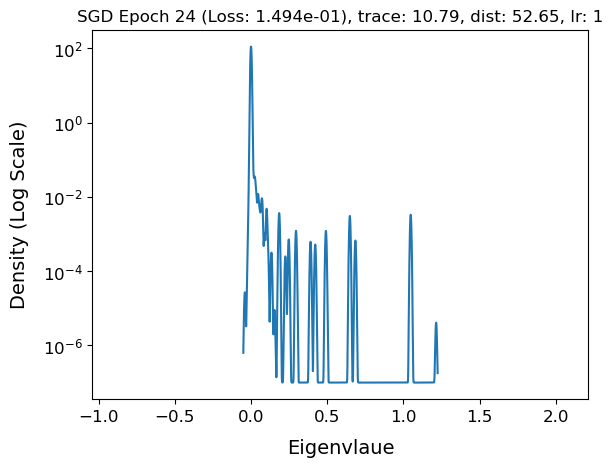

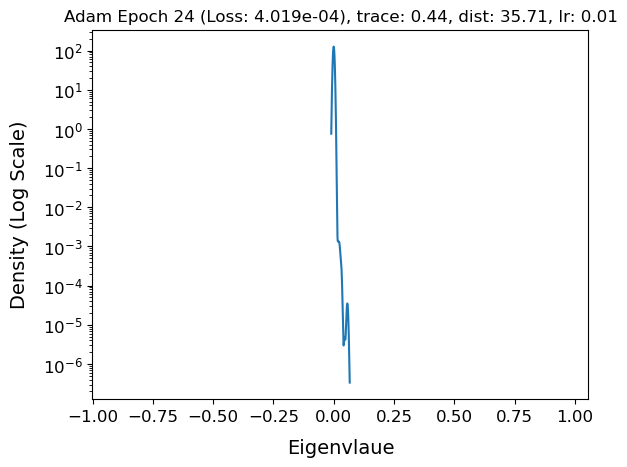

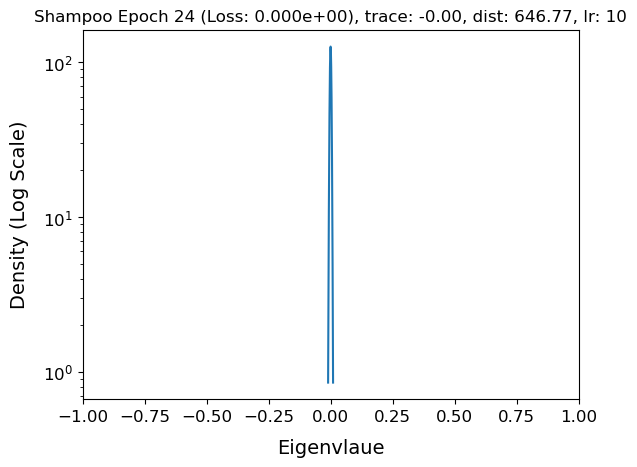

Epoch 25/30, Batch 1/32, Loss_SGD: 0.1481495052576065, Loss_Adam: 0.0003296992217656225, Loss_Adagrad: 0.0056358827278018, Loss_Shampoo: 0.0
Epoch 25/30, Batch 2/32, Loss_SGD: 0.11051806807518005, Loss_Adam: 0.0003547248779796064, Loss_Adagrad: 0.008341917768120766, Loss_Shampoo: 0.0
Epoch 25/30, Batch 3/32, Loss_SGD: 0.462588906288147, Loss_Adam: 0.0006193495937623084, Loss_Adagrad: 0.006825690157711506, Loss_Shampoo: 0.0
Epoch 25/30, Batch 4/32, Loss_SGD: 0.15733936429023743, Loss_Adam: 0.00040157389594241977, Loss_Adagrad: 0.004308579955250025, Loss_Shampoo: 0.0
Epoch 25/30, Batch 5/32, Loss_SGD: 0.1268867701292038, Loss_Adam: 0.00026573569630272686, Loss_Adagrad: 0.00343622756190598, Loss_Shampoo: 0.0
Epoch 25/30, Batch 6/32, Loss_SGD: 0.33663704991340637, Loss_Adam: 0.00037585123209282756, Loss_Adagrad: 0.012350764125585556, Loss_Shampoo: 0.0
Epoch 25/30, Batch 7/32, Loss_SGD: 0.1198054775595665, Loss_Adam: 0.0002560405118856579, Loss_Adagrad: 0.002826159819960594, Loss_Shampoo: 0

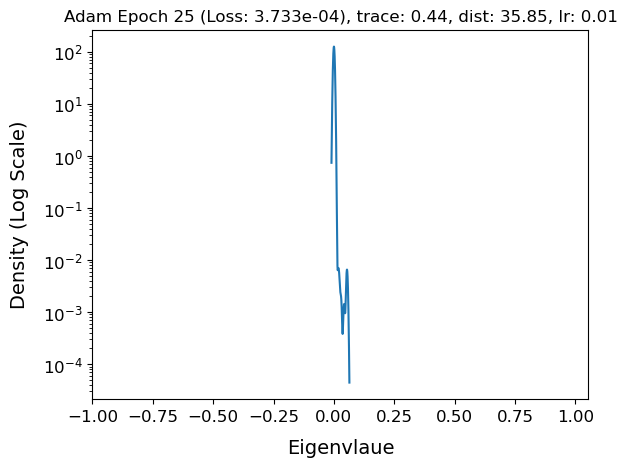

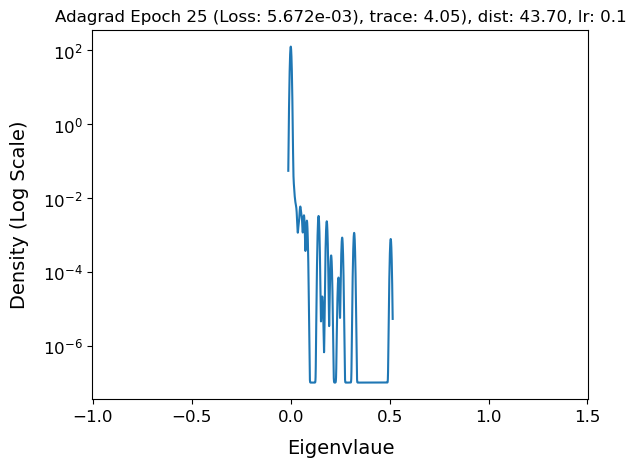

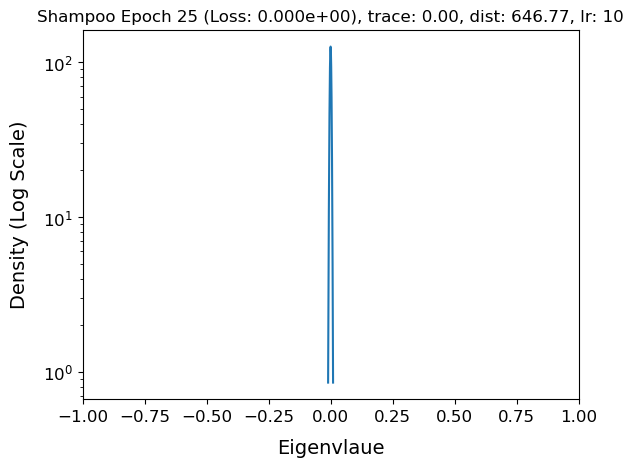

Epoch 26/30, Batch 1/32, Loss_SGD: 0.16244405508041382, Loss_Adam: 0.0004362793988548219, Loss_Adagrad: 0.0033046044409275055, Loss_Shampoo: 0.0
Epoch 26/30, Batch 2/32, Loss_SGD: 0.12849724292755127, Loss_Adam: 0.00023394974414259195, Loss_Adagrad: 0.002912994008511305, Loss_Shampoo: 0.0
Epoch 26/30, Batch 3/32, Loss_SGD: 0.184580460190773, Loss_Adam: 0.0006668400601483881, Loss_Adagrad: 0.0075081572867929935, Loss_Shampoo: 0.0
Epoch 26/30, Batch 4/32, Loss_SGD: 0.18590614199638367, Loss_Adam: 0.00027713310555554926, Loss_Adagrad: 0.004391336347907782, Loss_Shampoo: 0.0
Epoch 26/30, Batch 5/32, Loss_SGD: 0.14712192118167877, Loss_Adam: 0.00025615873164497316, Loss_Adagrad: 0.003166714683175087, Loss_Shampoo: 0.0
Epoch 26/30, Batch 6/32, Loss_SGD: 0.10329831391572952, Loss_Adam: 0.0004839723987970501, Loss_Adagrad: 0.003589443862438202, Loss_Shampoo: 0.0
Epoch 26/30, Batch 7/32, Loss_SGD: 0.2745482921600342, Loss_Adam: 0.00040177293703891337, Loss_Adagrad: 0.01590082049369812, Loss_Sha

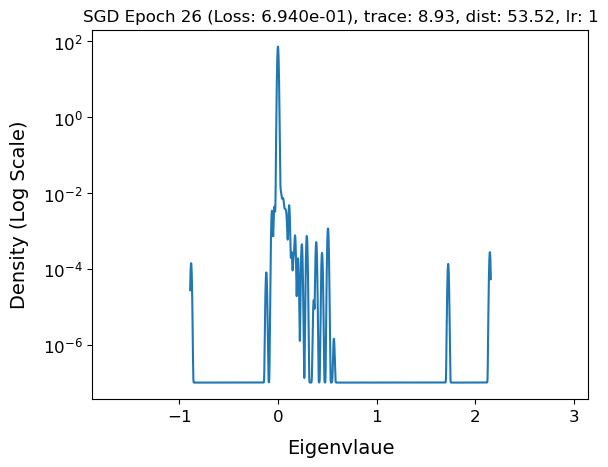

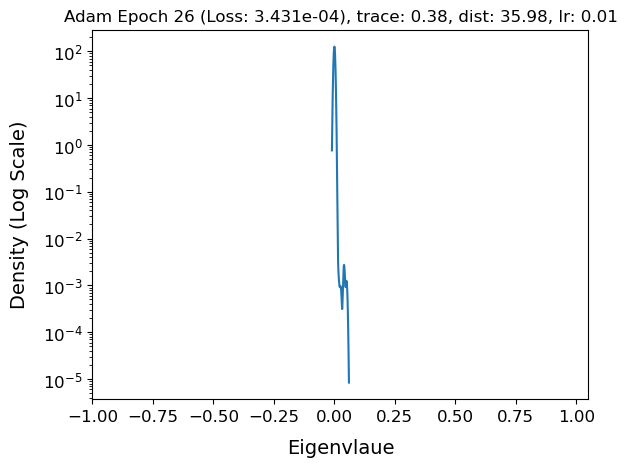

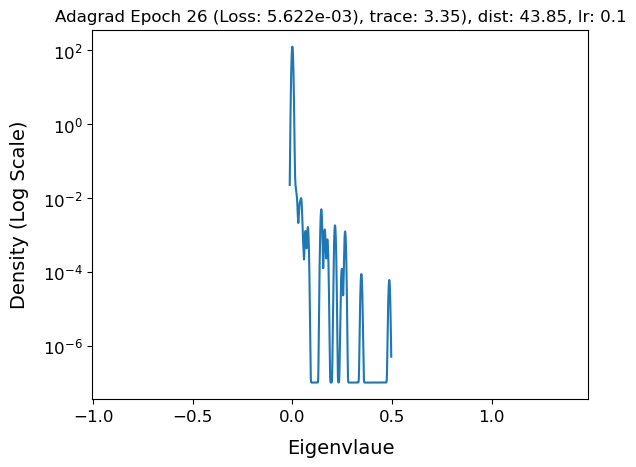

Epoch 27/30, Batch 1/32, Loss_SGD: 0.9462903738021851, Loss_Adam: 0.00036822480615228415, Loss_Adagrad: 0.003962681628763676, Loss_Shampoo: 0.0
Epoch 27/30, Batch 2/32, Loss_SGD: 0.6324543356895447, Loss_Adam: 0.00037376550608314574, Loss_Adagrad: 0.005908090155571699, Loss_Shampoo: 0.0
Epoch 27/30, Batch 3/32, Loss_SGD: 0.16967731714248657, Loss_Adam: 0.00040565727977082133, Loss_Adagrad: 0.0067216637544333935, Loss_Shampoo: 0.0
Epoch 27/30, Batch 4/32, Loss_SGD: 0.7342063784599304, Loss_Adam: 0.0003803242580033839, Loss_Adagrad: 0.0037808388005942106, Loss_Shampoo: 0.0
Epoch 27/30, Batch 5/32, Loss_SGD: 0.24945296347141266, Loss_Adam: 0.0003801699203904718, Loss_Adagrad: 0.0026429572608321905, Loss_Shampoo: 0.0
Epoch 27/30, Batch 6/32, Loss_SGD: 0.2411922663450241, Loss_Adam: 0.00038102135295048356, Loss_Adagrad: 0.005743704736232758, Loss_Shampoo: 0.0
Epoch 27/30, Batch 7/32, Loss_SGD: 0.06431926041841507, Loss_Adam: 0.0003082635230384767, Loss_Adagrad: 0.0039897761307656765, Loss_S

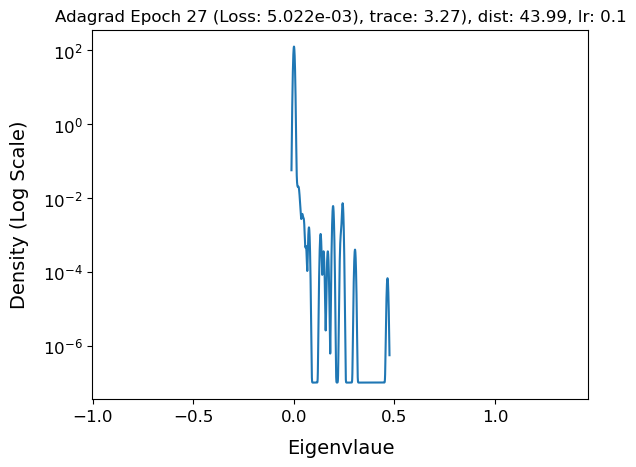

Epoch 28/30, Batch 1/32, Loss_SGD: 0.3573678731918335, Loss_Adam: 0.0005493306671269238, Loss_Adagrad: 0.01603848487138748, Loss_Shampoo: 0.0
Epoch 28/30, Batch 2/32, Loss_SGD: 0.3013322353363037, Loss_Adam: 0.00013914307055529207, Loss_Adagrad: 0.0018033767119050026, Loss_Shampoo: 0.0
Epoch 28/30, Batch 3/32, Loss_SGD: 0.1785128116607666, Loss_Adam: 0.00021024017769377679, Loss_Adagrad: 0.003469550283625722, Loss_Shampoo: 0.0
Epoch 28/30, Batch 4/32, Loss_SGD: 0.46369418501853943, Loss_Adam: 0.00030895238160155714, Loss_Adagrad: 0.00613834522664547, Loss_Shampoo: 0.0
Epoch 28/30, Batch 5/32, Loss_SGD: 0.1324397176504135, Loss_Adam: 0.00018188827380072325, Loss_Adagrad: 0.005284453742206097, Loss_Shampoo: 0.0
Epoch 28/30, Batch 6/32, Loss_SGD: 0.25092318654060364, Loss_Adam: 0.00031617723288945854, Loss_Adagrad: 0.003923845011740923, Loss_Shampoo: 0.0
Epoch 28/30, Batch 7/32, Loss_SGD: 0.24781258404254913, Loss_Adam: 0.00019052793504670262, Loss_Adagrad: 0.0021684428211301565, Loss_Sha

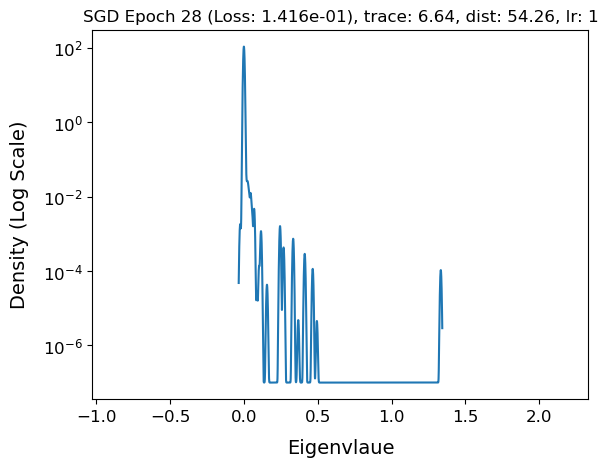

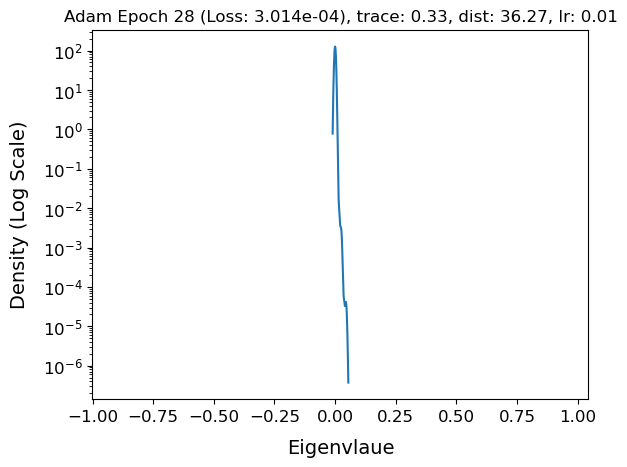

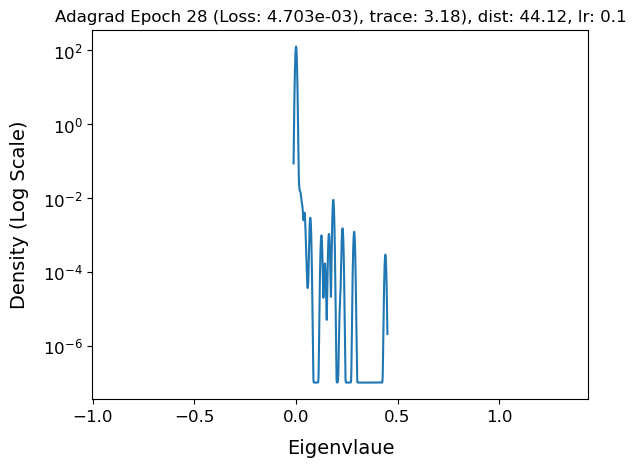

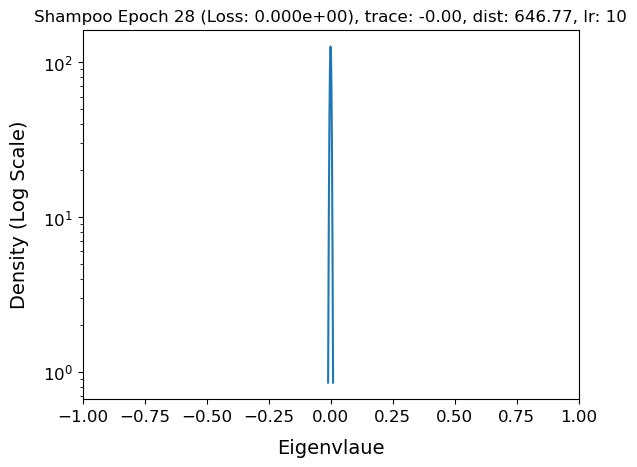

Epoch 29/30, Batch 1/32, Loss_SGD: 0.1606455296278, Loss_Adam: 0.0003876090922858566, Loss_Adagrad: 0.00627659959718585, Loss_Shampoo: 0.0
Epoch 29/30, Batch 2/32, Loss_SGD: 0.05783623829483986, Loss_Adam: 0.000308812886942178, Loss_Adagrad: 0.004293063655495644, Loss_Shampoo: 0.0
Epoch 29/30, Batch 3/32, Loss_SGD: 0.09828099608421326, Loss_Adam: 0.0003110335674136877, Loss_Adagrad: 0.0050168707966804504, Loss_Shampoo: 0.0
Epoch 29/30, Batch 4/32, Loss_SGD: 0.18922558426856995, Loss_Adam: 0.0003378311521373689, Loss_Adagrad: 0.003917759750038385, Loss_Shampoo: 0.0
Epoch 29/30, Batch 5/32, Loss_SGD: 0.06518276035785675, Loss_Adam: 0.0002463007112964988, Loss_Adagrad: 0.002240824745967984, Loss_Shampoo: 0.0
Epoch 29/30, Batch 6/32, Loss_SGD: 0.03837602213025093, Loss_Adam: 0.00016419426538050175, Loss_Adagrad: 0.0012189254630357027, Loss_Shampoo: 0.0
Epoch 29/30, Batch 7/32, Loss_SGD: 0.09349000453948975, Loss_Adam: 0.00020048535952810198, Loss_Adagrad: 0.0035463275853544474, Loss_Shampo

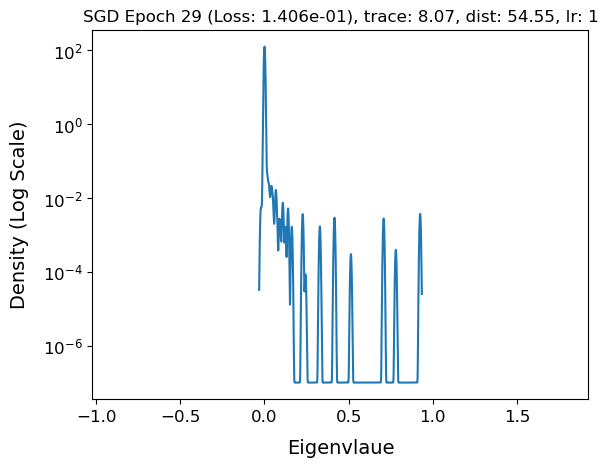

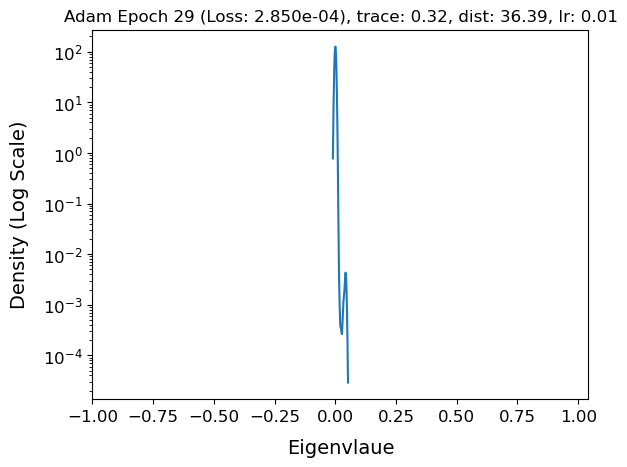

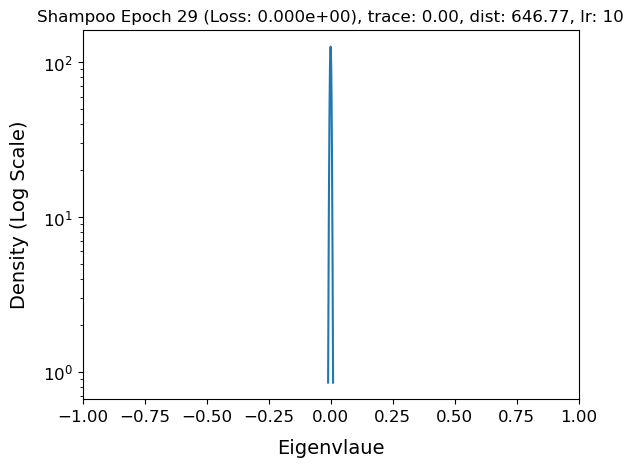

Epoch 30/30, Batch 1/32, Loss_SGD: 0.14857222139835358, Loss_Adam: 0.0003325063444208354, Loss_Adagrad: 0.005301632918417454, Loss_Shampoo: 0.0
Epoch 30/30, Batch 2/32, Loss_SGD: 0.16953638195991516, Loss_Adam: 0.0003203849773854017, Loss_Adagrad: 0.00956530962139368, Loss_Shampoo: 0.0
Epoch 30/30, Batch 3/32, Loss_SGD: 0.06593327969312668, Loss_Adam: 0.0001831673871492967, Loss_Adagrad: 0.00307488557882607, Loss_Shampoo: 0.0
Epoch 30/30, Batch 4/32, Loss_SGD: 0.14630290865898132, Loss_Adam: 0.000248274824116379, Loss_Adagrad: 0.003827011678367853, Loss_Shampoo: 0.0
Epoch 30/30, Batch 5/32, Loss_SGD: 0.0671687051653862, Loss_Adam: 0.0003943120827898383, Loss_Adagrad: 0.005357738118618727, Loss_Shampoo: 0.0
Epoch 30/30, Batch 6/32, Loss_SGD: 0.13073612749576569, Loss_Adam: 0.00018071972590405494, Loss_Adagrad: 0.0022180243395268917, Loss_Shampoo: 0.0
Epoch 30/30, Batch 7/32, Loss_SGD: 0.06214575469493866, Loss_Adam: 0.0005086576566100121, Loss_Adagrad: 0.013631979934871197, Loss_Shampoo

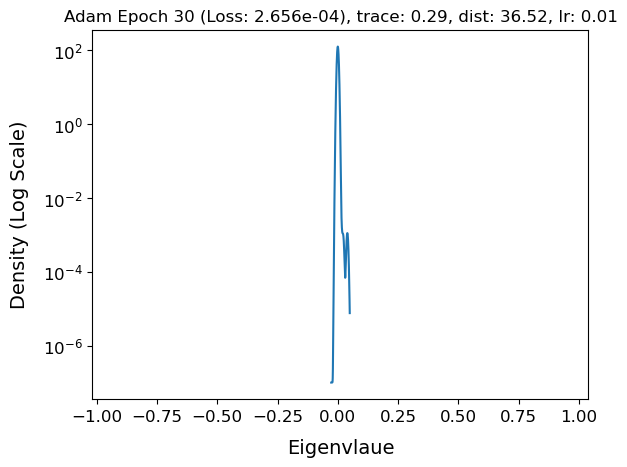

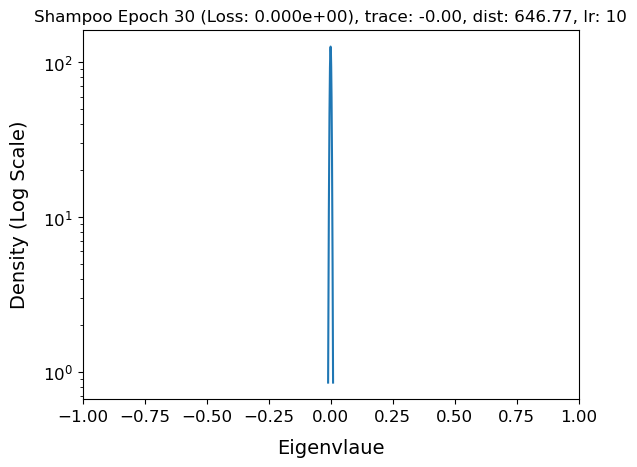

In [13]:
dist_SGD = []
dist_Adam = []
dist_Adagrad = []
dist_Shampoo = []

train_losses_SGD = []
train_losses_Adam = []
train_losses_Adagrad = []
train_losses_Shampoo = []

full_train_loss_SGD = []
full_train_loss_Adam = []
full_train_loss_Adagrad = []
full_train_loss_Shampoo = []

traces_SGD = []
traces_Adam = []
traces_Adagrad = []
traces_Shampoo = []

epochs = 30

hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_Adagrad = hessian(model_Adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_shampoo = hessian(model_Shampoo, criterion, dataloader=hessian_loader, cuda=cuda)

traces_SGD.append(np.mean(hessian_sgd.trace()))
traces_Adam.append(np.mean(hessian_adam.trace()))
traces_Adagrad.append(np.mean(hessian_Adagrad.trace()))
traces_Shampoo.append(np.mean(hessian_shampoo.trace()))

for epoch in range(epochs):
    model_SGD.train()
    model_Adam.train()
    model_Adagrad.train()
    model_Shampoo.train()
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_SGD.zero_grad()
        optimizer_Adam.zero_grad()
        optimizer_Adagrad.zero_grad()
        optimizer_Shampoo.zero_grad()
        y_pred_SGD = model_SGD(x_batch)
        y_pred_Adam = model_Adam(x_batch)
        y_pred_Adagrad = model_Adagrad(x_batch)
        y_pred_Shampoo = model_Shampoo(x_batch)
        loss_SGD = criterion(y_pred_SGD, y_batch)
        loss_Adam = criterion(y_pred_Adam, y_batch)
        loss_Adagrad = criterion(y_pred_Adagrad, y_batch)
        loss_Shampoo = criterion(y_pred_Shampoo, y_batch)
        train_losses_SGD.append(loss_SGD.item())
        train_losses_Adam.append(loss_Adam.item())
        train_losses_Adagrad.append(loss_Adagrad.item())
        train_losses_Shampoo.append(loss_Shampoo.item())
        loss_SGD.backward()
        loss_Adam.backward()
        loss_Adagrad.backward()
        loss_Shampoo.backward()
        optimizer_SGD.step()
        optimizer_Adam.step()
        optimizer_Adagrad.step()
        optimizer_Shampoo.step()
        print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_Adagrad: {loss_Adagrad.item()}, Loss_Shampoo: {loss_Shampoo.item()}")
    
    full_sgd_loss = full_loss(model_SGD, criterion, dataloader)
    full_adam_loss = full_loss(model_Adam, criterion, dataloader)
    full_adagrad_loss = full_loss(model_Adagrad, criterion, dataloader)
    full_shampoo_loss = full_loss(model_Shampoo, criterion, dataloader)
    
    full_train_loss_SGD.append(full_sgd_loss)
    full_train_loss_Adam.append(full_adam_loss)
    full_train_loss_Adagrad.append(full_adagrad_loss)
    full_train_loss_Shampoo.append(full_shampoo_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss_SGD: {full_sgd_loss}, Loss_Adam: {full_adam_loss}, Loss_Adagrad: {full_adagrad_loss}, Loss_Shampoo: {full_shampoo_loss}")
    
    dist_SGD.append(distance(model_SGD, init_model))
    dist_Adam.append(distance(model_Adam, init_model))
    dist_Adagrad.append(distance(model_Adagrad, init_model))
    dist_Shampoo.append(distance(model_Shampoo, init_model))

    print(f"Epoch {epoch+1}/{epochs}, Dist_SGD: {dist_SGD[-1]}, Dist_Adam: {dist_Adam[-1]}, Dist_Adagrad: {dist_Adagrad[-1]}, Dist_Shampoo: {dist_Shampoo[-1]}")

    hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_Adagrad = hessian(model_Adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_shampoo = hessian(model_Shampoo, criterion, dataloader=hessian_loader, cuda=cuda)
    traces_SGD.append(np.mean(hessian_sgd.trace()))
    traces_Adam.append(np.mean(hessian_adam.trace()))
    traces_Adagrad.append(np.mean(hessian_Adagrad.trace()))
    traces_Shampoo.append(np.mean(hessian_shampoo.trace()))
    
    print(f"Epoch {epoch+1}/{epochs}, Trace_SGD: {traces_SGD[-1]}, Trace_Adam: {traces_Adam[-1]}, Trace_Adagrad: {traces_Adagrad[-1]}, Trace_Shampoo: {traces_Shampoo[-1]}") 
    get_esd_plot(*hessian_sgd.density(), title=f'SGD Epoch {epoch+1} (Loss: {full_sgd_loss:.3e}), trace: {traces_SGD[-1]:.2f}, dist: {dist_SGD[-1]:.2f}, lr: {lrs[minindex_SGD]}', save_path=f"hess_spectrum_images/SGD/epoch_{epoch+1}.png")
    plt.show()
    get_esd_plot(*hessian_adam.density(), title=f'Adam Epoch {epoch+1} (Loss: {full_adam_loss:.3e}), trace: {traces_Adam[-1]:.2f}, dist: {dist_Adam[-1]:.2f}, lr: {lrs[minindex_Adam]}', save_path=f"hess_spectrum_images/Adam/epoch_{epoch+1}.png")
    plt.show()
    get_esd_plot(*hessian_Adagrad.density(), title=f'Adagrad Epoch {epoch+1} (Loss: {full_adagrad_loss:.3e}), trace: {traces_Adagrad[-1]:.2f}), dist: {dist_Adagrad[-1]:.2f}, lr: {lrs[minindex_Adagrad]}', save_path=f"hess_spectrum_images/Adagrad/epoch_{epoch+1}.png")
    plt.show()
    get_esd_plot(*hessian_shampoo.density(), title=f'Shampoo Epoch {epoch+1} (Loss: {full_shampoo_loss:.3e}), trace: {traces_Shampoo[-1]:.2f}, dist: {dist_Shampoo[-1]:.2f}, lr: {lrs[minindex_Shampoo]}', save_path=f"hess_spectrum_images/Shampoo/epoch_{epoch+1}.png")
    plt.show()

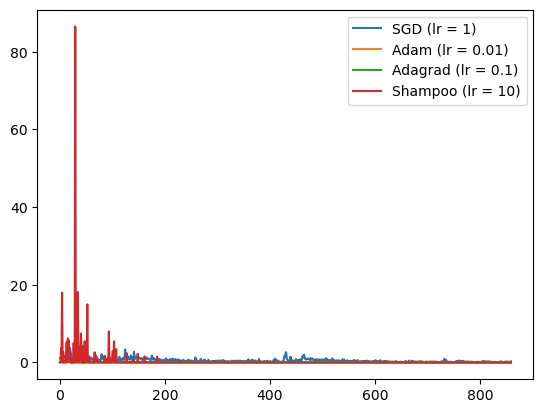

In [14]:
# Plotting the loss curves
plt.plot(train_losses_SGD[100:], label=f'SGD (lr = {lrs[minindex_SGD]})')
plt.plot(train_losses_Adam[100:], label=f'Adam (lr = {lrs[minindex_Adam]})')
plt.plot(train_losses_Adagrad[100:], label=f'Adagrad (lr = {lrs[minindex_Adagrad]})')
plt.plot(train_losses_Shampoo[100:], label=f'Shampoo (lr = {lrs[minindex_Shampoo]})')
plt.legend()
plt.show()

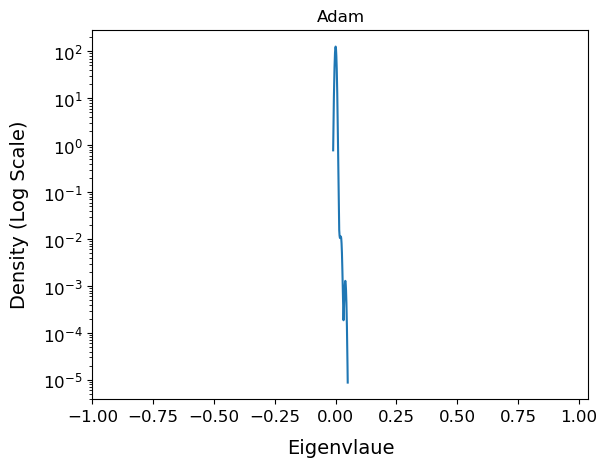

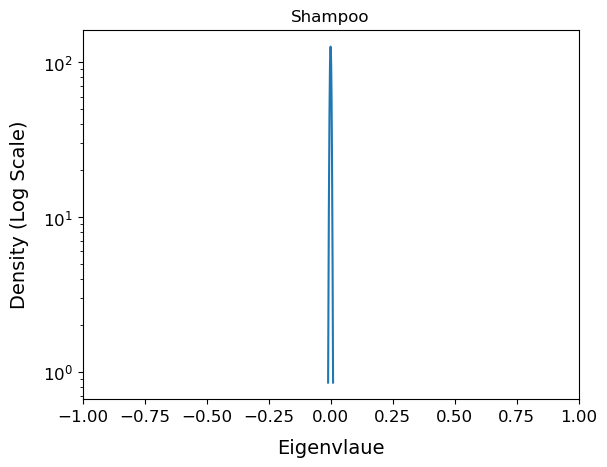

In [15]:
# Plot the ending ESD of the Hessian in all three cases
hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_Adagrad = hessian(model_Adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_shampoo = hessian(model_Shampoo, criterion, dataloader=hessian_loader, cuda=cuda)
get_esd_plot(*hessian_sgd.density(), title='SGD')
get_esd_plot(*hessian_adam.density(), title='Adam')
get_esd_plot(*hessian_Adagrad.density(), title='Adagrad')
get_esd_plot(*hessian_shampoo.density(), title='Shampoo')
plt.show()

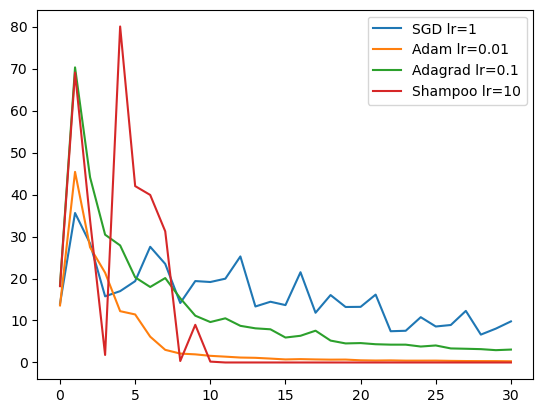

In [16]:
plt.plot(traces_SGD, label=f'SGD lr={sgd_lr}')
plt.plot(traces_Adam, label=f'Adam lr={adam_lr}')
plt.plot(traces_Adagrad, label=f'Adagrad lr={adagrad_lr}')
plt.plot(traces_Shampoo, label=f'Shampoo lr={shampoo_lr}')
plt.legend()
plt.show()

In [17]:
dist_SGD = [d.item() for d in dist_SGD]
dist_Adam = [d.item() for d in dist_Adam]
dist_Adagrad = [d.item() for d in dist_Adagrad]
dist_Shampoo = [d.item() for d in dist_Shampoo]

In [18]:
plt.plot(dist_SGD, label=f'SGD lr={sgd_lr}')
plt.plot(dist_Adam, label=f'Adam lr={adam_lr}')
plt.plot(dist_Adagrad, label=f'Adagrad lr={adagrad_lr}')
plt.plot(dist_Shampoo, label=f'Shampoo lr={shampoo_lr}')
plt.title('Distance from init')
plt.xlabel('Epoch')
plt.ylabel('Distance from init')
plt.legend()

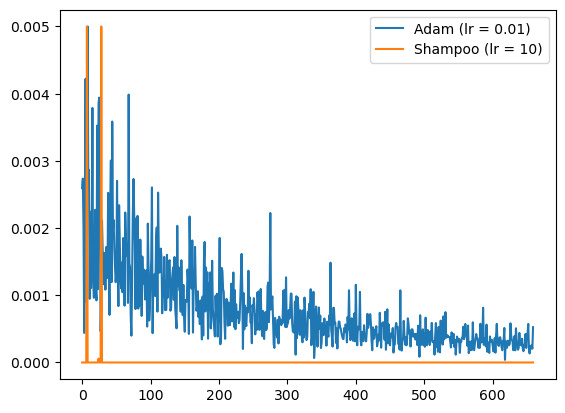

In [23]:
#plt.plot(train_losses_SGD[300:], label=f'SGD (lr = {lrs[minindex_SGD]})')
plt.plot(np.clip(train_losses_Adam[300:],0,0.005), label=f'Adam (lr = {lrs[minindex_Adam]})')
#plt.plot(train_losses_Adagrad[300:], label=f'Adagrad (lr = {lrs[minindex_Adagrad]})')
plt.plot(np.clip(train_losses_Shampoo[300:], 0, 0.005), label=f'Shampoo (lr = {lrs[minindex_Shampoo]})')
plt.legend()
plt.show()